# Child Mind Institute - Detect Sleep States
### A Collaborative Project
##### Contributors: David Hartsman, Kendall McNeil, Heath Jones, Kacey Clougher, Andrew Friedrichs, Gavin Martin

<hr style="border: 4px solid blue">

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## From Kaggle Description

Dataset Description
The dataset comprises about 500 multi-day recordings of wrist-worn accelerometer data annotated with two event types: onset, the beginning of sleep, and wakeup, the end of sleep. Your task is to detect the occurrence of these two events in the accelerometer series.

While sleep logbooks remain the gold-standard, when working with accelerometer data we refer to sleep as the longest single period of inactivity while the watch is being worn. For this data, we have guided raters with several concrete instructions:

A single sleep period must be at least 30 minutes in length
A single sleep period can be interrupted by bouts of activity that do not exceed 30 consecutive minutes
No sleep windows can be detected unless the watch is deemed to be worn for the duration (elaborated upon, below)
The longest sleep window during the night is the only one which is recorded
If no valid sleep window is identifiable, neither an onset nor a wakeup event is recorded for that night.
Sleep events do not need to straddle the day-line, and therefore there is no hard rule defining how many may occur within a given period. However, no more than one window should be assigned per night. For example, it is valid for an individual to have a sleep window from 01h00–06h00 and 19h00–23h30 in the same calendar day, though assigned to consecutive nights
There are roughly as many nights recorded for a series as there are 24-hour periods in that series.
Though each series is a continuous recording, there may be periods in the series when the accelerometer device was removed. These period are determined as those where suspiciously little variation in the accelerometer signals occur over an extended period of time, which is unrealistic for typical human participants. Events are not annotated for these periods, and you should attempt to refrain from making event predictions during these periods: an event prediction will be scored as false positive.

Each data series represents this continuous (multi-day/event) recording for a unique experimental subject.

Files and Field Descriptions
- train_series.parquet - Series to be used as training data. Each series is a continuous recording of accelerometer data for a single subject spanning many days.

- series_id - Unique identifier for each accelerometer series.

- step - An integer timestep for each observation within a series.

- timestamp - A corresponding datetime with ISO 8601 format %Y-%m-%dT%H:%M:%S%z.

- anglez - As calculated and described by the GGIR package, z-angle is a metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body

- enmo - As calculated and described by the GGIR package, ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features

---

- test_series.parquet - Series to be used as the test data, containing the same fields as above. You will predict event occurrences for series in this file.

- train_events.csv - Sleep logs for series in the training set recording onset and wake events.

- series_id - Unique identifier for each series of accelerometer data in train_series.parquet.

- night - An enumeration of potential onset / wakeup event pairs. At most one pair of events can occur for each night.

- event - The type of event, whether onset or wakeup.

- step and timestamp - The recorded time of occurence of the event in the accelerometer series.

### Importing the training data and labels
The training data is data from many different users over periods of time that differ slightly, but are more or less around a month. The observations are taken from the accelerometer every 5 seconds. The classification task will be to identify the moment that someone falls asleep, wakes up, and all other observations would represent a state of being awake. In other words, there will be `3 classes`: *Awake*, *Falling Asleep*, and *Waking Up*.

In [3]:
# Required library to read the training observations

# pip install fastparquet

In [4]:
# Observations - takes more or less one minute to read into memory

df = pd.read_parquet('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/child-mind-institute-detect-sleep-states/train_series.parquet')

In [5]:
# Data inspection

print(df.shape)
df.head()

(127946340, 5)


series_id  step                 timestamp  anglez    enmo
0  038441c925bb   0.0  2018-08-14T15:30:00-0400  2.6367  0.0217
1  038441c925bb   1.0  2018-08-14T15:30:05-0400  2.6368  0.0215
2  038441c925bb   2.0  2018-08-14T15:30:10-0400  2.6370  0.0216
3  038441c925bb   3.0  2018-08-14T15:30:15-0400  2.6368  0.0213
4  038441c925bb   4.0  2018-08-14T15:30:20-0400  2.6368  0.0215

In [6]:
# Labels

labels = pd.read_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/child-mind-institute-detect-sleep-states/train_events.csv')

In [7]:
# Label inspection
print(labels.shape)
labels.head()

(14508, 5)


series_id  night   event     step                 timestamp
0  038441c925bb      1   onset   4992.0  2018-08-14T22:26:00-0400
1  038441c925bb      1  wakeup  10932.0  2018-08-15T06:41:00-0400
2  038441c925bb      2   onset  20244.0  2018-08-15T19:37:00-0400
3  038441c925bb      2  wakeup  27492.0  2018-08-16T05:41:00-0400
4  038441c925bb      3   onset  39996.0  2018-08-16T23:03:00-0400

In [8]:
### Number of unique series_ids corresponding to individuals in the study

participants = labels["series_id"].nunique()
print(f"There are {participants} distinct participants in this sleep study.")

There are 277 distinct participants in this sleep study.


<hr style="border: 4px solid blue">

### Choosing a subset of data to work with: (optional skip to choosing 1 subject)
I am going to elect to choose data from the middle of the training set to explore, and possibly begin some small modeling exercises. I am using this smaller subset because the full dataset is `too large` for fast-and-easy maniupulation while I am choosing features and exploring data. 

In [19]:
# Choosing the 113th - 123rd users

df.groupby("series_id").agg({"anglez":["mean", "std", "var"],
                            "enmo":["mean", "std", "var"]})[113:123]

anglez                              enmo                    
                   mean        std          var      mean       std       var
series_id                                                                    
6d6b9d22d48a  -4.392521  35.934021  1290.646973  0.042363  0.110069  0.012138
6ee4ade1f2bd   6.804501  39.088417  1527.667847  0.050708  0.100100  0.010017
702bb5387b1e -12.808884  33.738789  1138.071655  0.045567  0.089844  0.008072
703b5efa9bc1 -31.449821  27.038307   730.982117  0.026132  0.064227  0.004125
72ba4a8afff4  -7.705407  32.686913  1068.185181  0.045479  0.109939  0.012080
72bbd1ac3edf -10.810487  36.011448  1296.692139  0.053229  0.117309  0.013757
72d2234e84e4 -19.330164  37.191933  1382.580078  0.041793  0.104735  0.010990
73fb772e50fb -18.003159  26.684101   711.836182  0.047561  0.070098  0.004912
7476c0bd18d2  -6.766726  29.072927   845.125549  0.036809  0.060544  0.003664
7504165f497d  17.920420  35.464188  1257.463989  0.039921  0.105606  0.011147

In [20]:
# Random-ish Data Selection - still takes about 30-40 seconds to run

df_sub = df.loc['6d6b9d22d48a':'7504165f497d', :].copy()

In [21]:
# Subset inspection - still over 5M rows of data

print(df_sub.shape)
df_sub.head()

(5041660, 5)


series_id      step                 timestamp     anglez    enmo
70000000  91cb6c98201f  297520.0  2019-02-22T16:43:20-0500  21.453400  0.0026
70000001  91cb6c98201f  297521.0  2019-02-22T16:43:25-0500  24.361799  0.0003
70000002  91cb6c98201f  297522.0  2019-02-22T16:43:30-0500  22.117701  0.0001
70000003  91cb6c98201f  297523.0  2019-02-22T16:43:35-0500  20.762501  0.0007
70000004  91cb6c98201f  297524.0  2019-02-22T16:43:40-0500   5.394000  0.0000

In [79]:
# Choosing an individual user's data to perform EDA on

user = df[df["series_id"] == "91cb6c98201f"]

In [80]:
# User Labels

user_labels = labels[labels["series_id"] == "91cb6c98201f"]

In [81]:
user_labels["date"] = pd.to_datetime(user_labels["timestamp"]).dt.date

In [82]:
user_labels.head()

series_id  night   event     step                 timestamp  \
7854  91cb6c98201f      1   onset   6384.0  2019-02-05T20:22:00-0500   
7855  91cb6c98201f      1  wakeup  13632.0  2019-02-06T06:26:00-0500   
7856  91cb6c98201f      2   onset  23484.0  2019-02-06T20:07:00-0500   
7857  91cb6c98201f      2  wakeup  30948.0  2019-02-07T06:29:00-0500   
7858  91cb6c98201f      3   onset  43380.0  2019-02-07T23:45:00-0500   

            date  
7854  2019-02-05  
7855  2019-02-06  
7856  2019-02-06  
7857  2019-02-07  
7858  2019-02-07

In [83]:
# Timestamp is a string, so will need to convert it to a datetime object and extract elements from it, 
# also potentially eventually setting it as the index

user.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415980 entries, 69702480 to 70118459
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   series_id  415980 non-null  object 
 1   step       415980 non-null  float64
 2   timestamp  415980 non-null  object 
 3   anglez     415980 non-null  float32
 4   enmo       415980 non-null  float32
dtypes: float32(2), float64(1), object(2)
memory usage: 15.9+ MB


In [34]:
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

In [84]:
# Creating a datetime of the date by itself

user["date"] = pd.to_datetime(user["timestamp"]).dt.date

In [199]:
user["date"].unique()

array([datetime.date(2019, 2, 5), datetime.date(2019, 2, 6),
       datetime.date(2019, 2, 7), datetime.date(2019, 2, 8),
       datetime.date(2019, 2, 9), datetime.date(2019, 2, 10),
       datetime.date(2019, 2, 11), datetime.date(2019, 2, 12),
       datetime.date(2019, 2, 13), datetime.date(2019, 2, 14),
       datetime.date(2019, 2, 15), datetime.date(2019, 2, 16),
       datetime.date(2019, 2, 17), datetime.date(2019, 2, 18),
       datetime.date(2019, 2, 19), datetime.date(2019, 2, 20),
       datetime.date(2019, 2, 21), datetime.date(2019, 2, 22),
       datetime.date(2019, 2, 23), datetime.date(2019, 2, 24),
       datetime.date(2019, 2, 25), datetime.date(2019, 2, 26),
       datetime.date(2019, 2, 27), datetime.date(2019, 2, 28),
       datetime.date(2019, 3, 1)], dtype=object)

In [94]:
user.merge(user_labels, on="step", how="left", suffixes=["_train", "_label"])

series_id_train      step           timestamp_train     anglez    enmo  \
0         91cb6c98201f       0.0  2019-02-05T11:30:00-0500 -77.418602  0.0292   
1         91cb6c98201f       1.0  2019-02-05T11:30:05-0500 -77.474098  0.0296   
2         91cb6c98201f       2.0  2019-02-05T11:30:10-0500 -77.515503  0.0298   
3         91cb6c98201f       3.0  2019-02-05T11:30:15-0500 -77.583199  0.0302   
4         91cb6c98201f       4.0  2019-02-05T11:30:20-0500 -77.592003  0.0306   
...                ...       ...                       ...        ...     ...   
415975    91cb6c98201f  415975.0  2019-03-01T13:14:35-0500  -7.281200  0.0581   
415976    91cb6c98201f  415976.0  2019-03-01T13:14:40-0500  -9.926700  0.0566   
415977    91cb6c98201f  415977.0  2019-03-01T13:14:45-0500  -7.776200  0.0468   
415978    91cb6c98201f  415978.0  2019-03-01T13:14:50-0500  -6.603500  0.0466   
415979    91cb6c98201f  415979.0  2019-03-01T13:14:55-0500  -5.839900  0.0498   

        date_train series_id_label  night event timestamp_label date_label  
0       2019-02-05             NaN    NaN   NaN             NaN        NaN  
1       2019-02-05             NaN    NaN   NaN             NaN        NaN  
2       2019-02-05             NaN    NaN   NaN             NaN        NaN  
3       2019-02-05             NaN    NaN   NaN             NaN        NaN  
4       2019-02-05             NaN    NaN   NaN             NaN        NaN  
...            ...             ...    ...   ...             ...        ...  
415975  2019-03-01             NaN    NaN   NaN             NaN        NaN  
415976  2019-03-01             NaN    NaN   NaN             NaN        NaN  
415977  2019-03-01             NaN    NaN   NaN             NaN        NaN  
415978  2019-03-01             NaN    NaN   NaN             NaN        NaN  
415979  2019-03-01             NaN    NaN   NaN             NaN        NaN  

[415980 rows x 11 columns]

<hr style="border: 4px solid blue">

### Visualizing the data

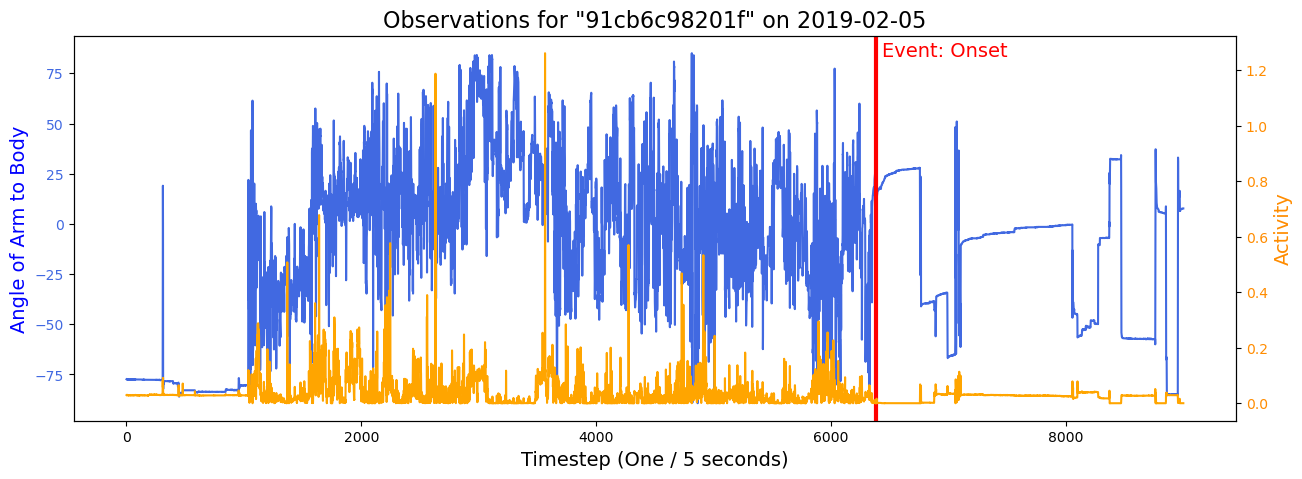

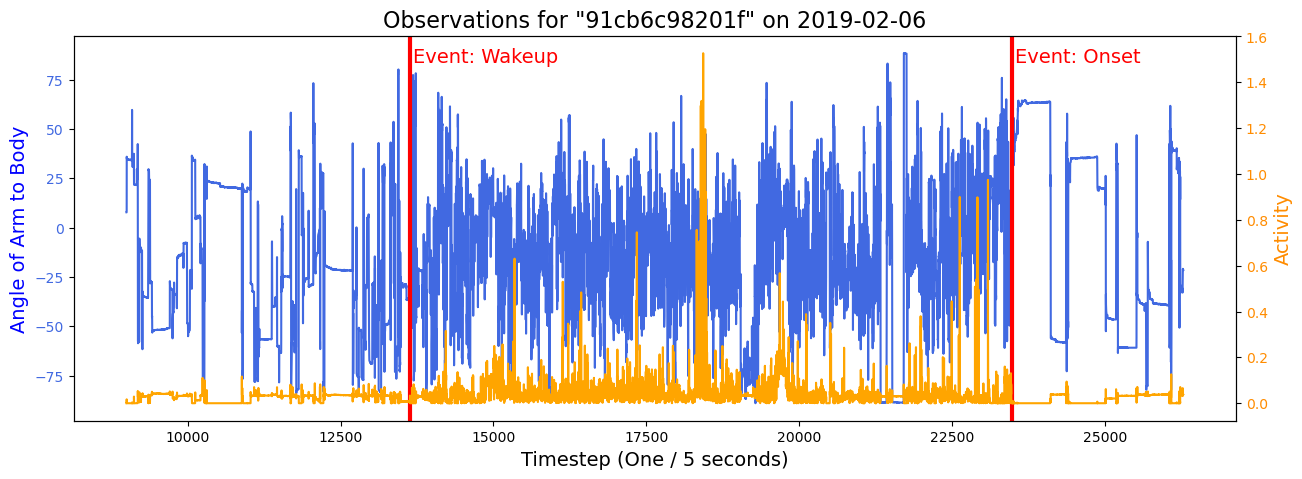

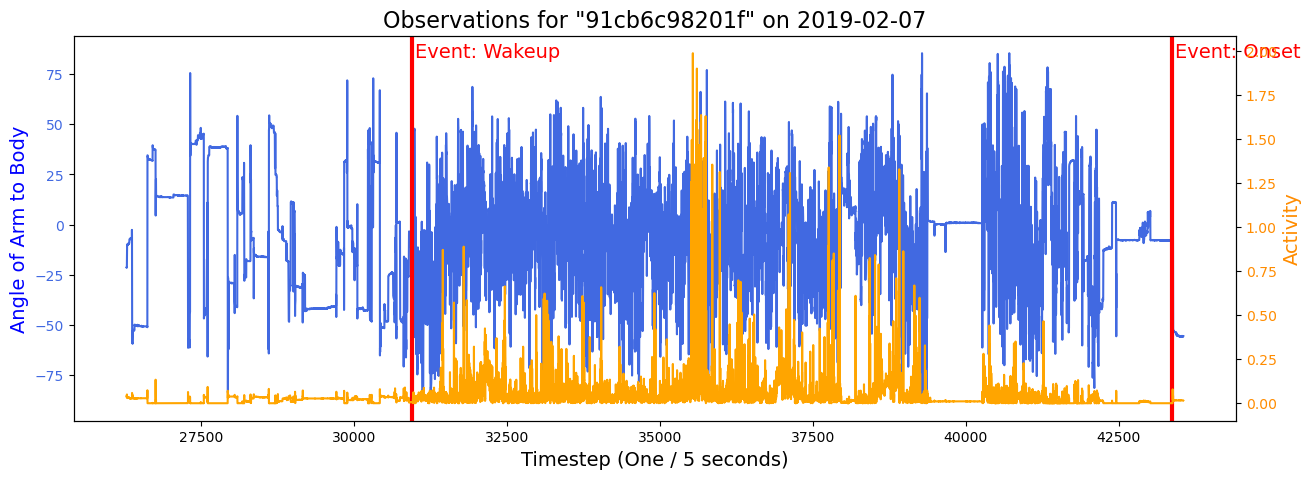

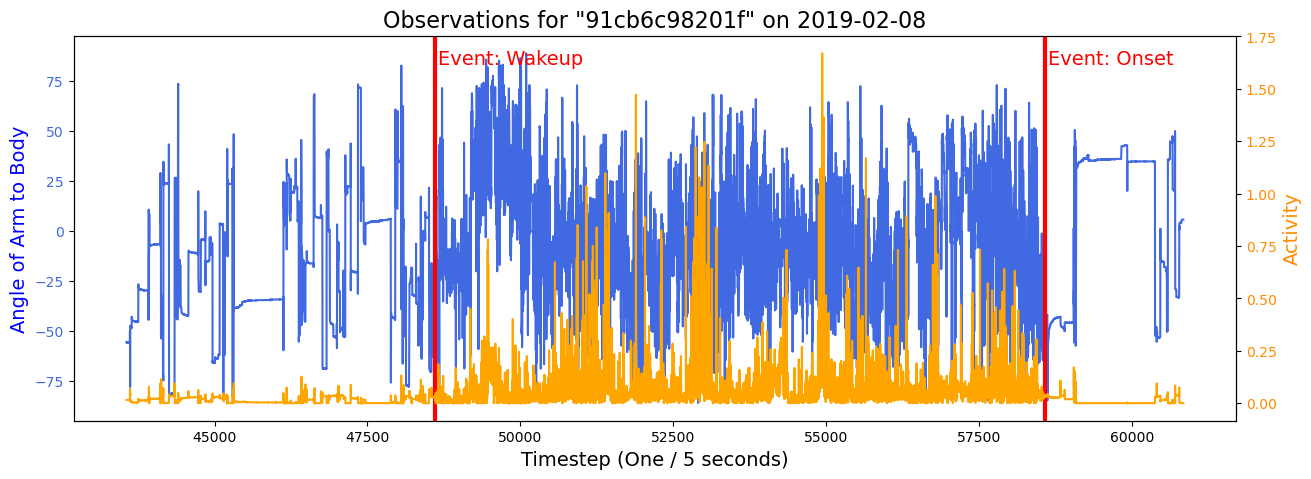

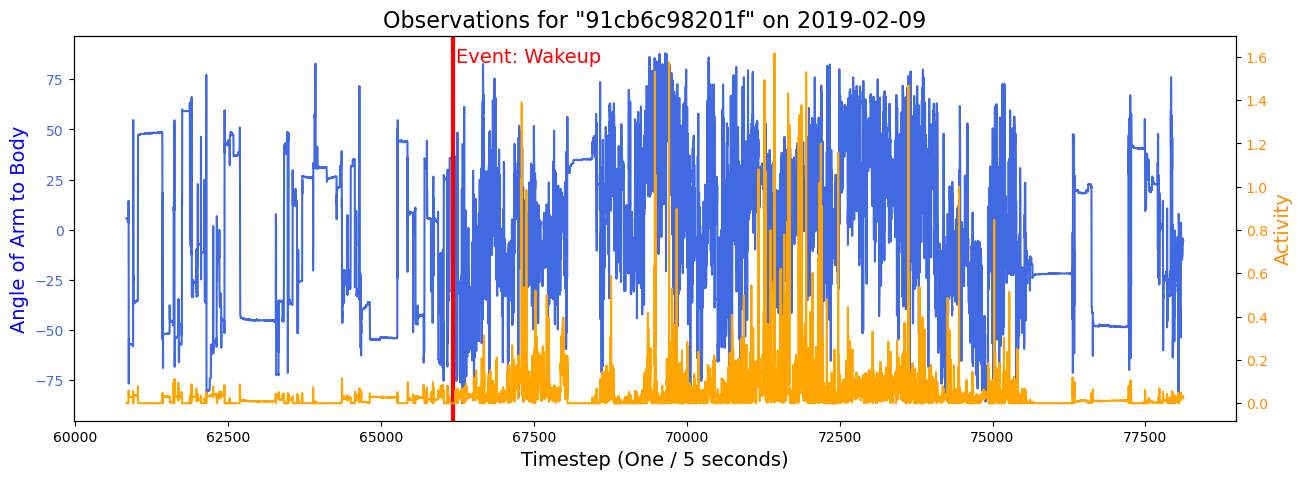

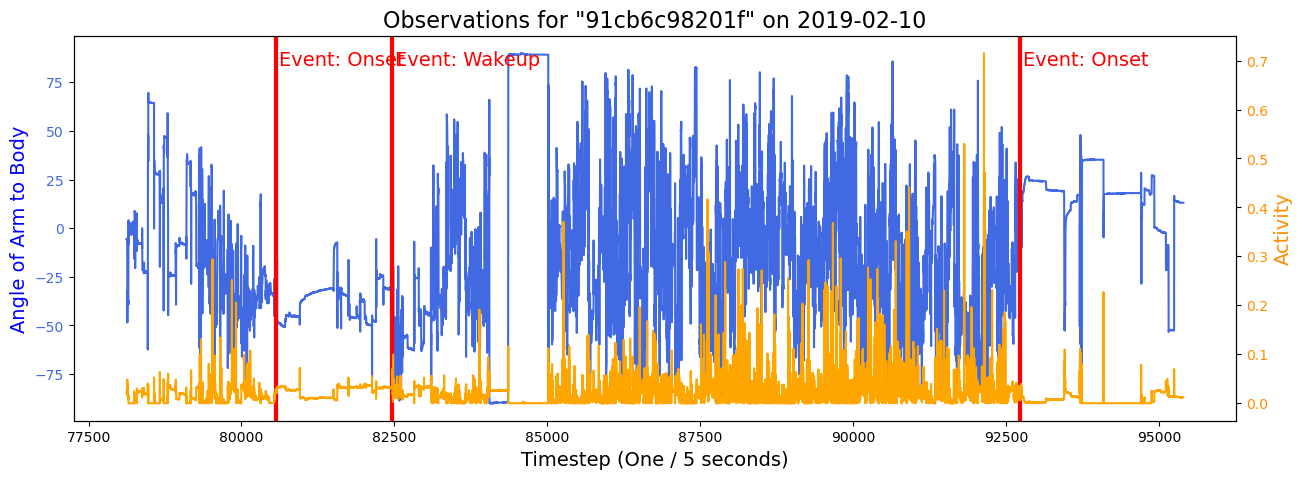

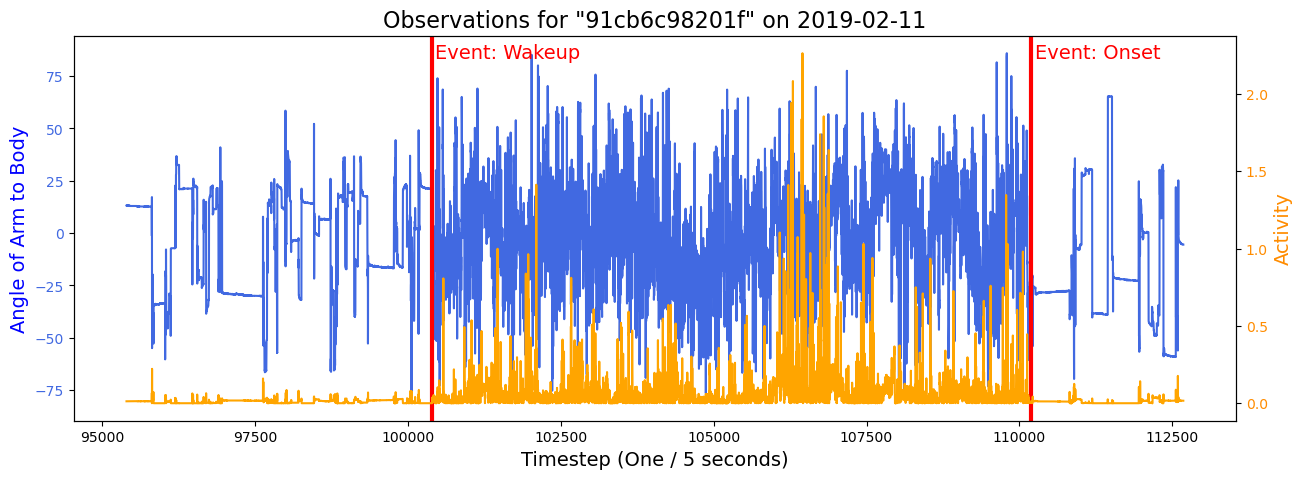

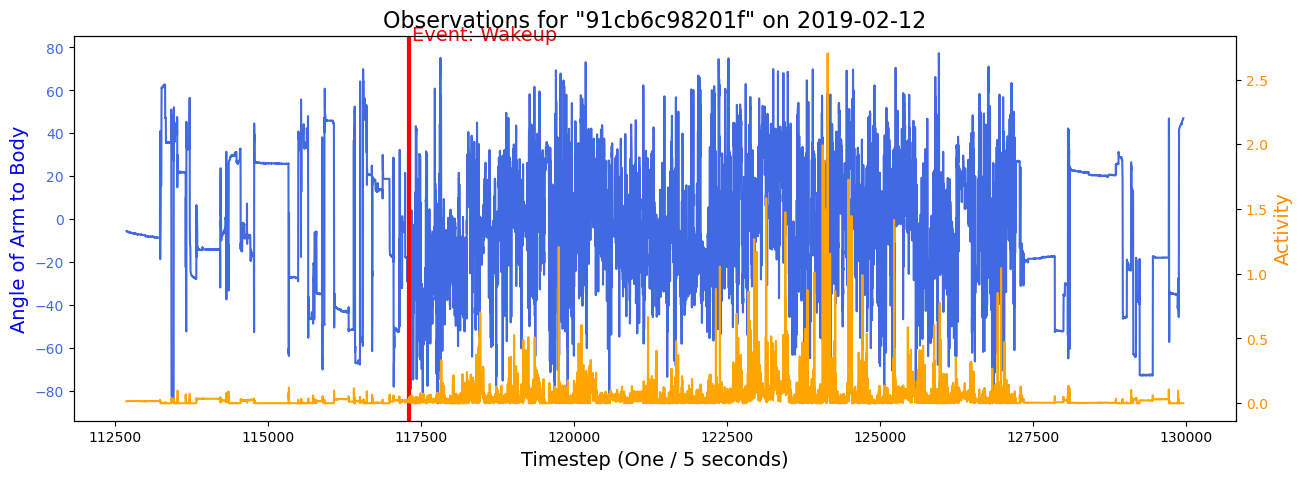

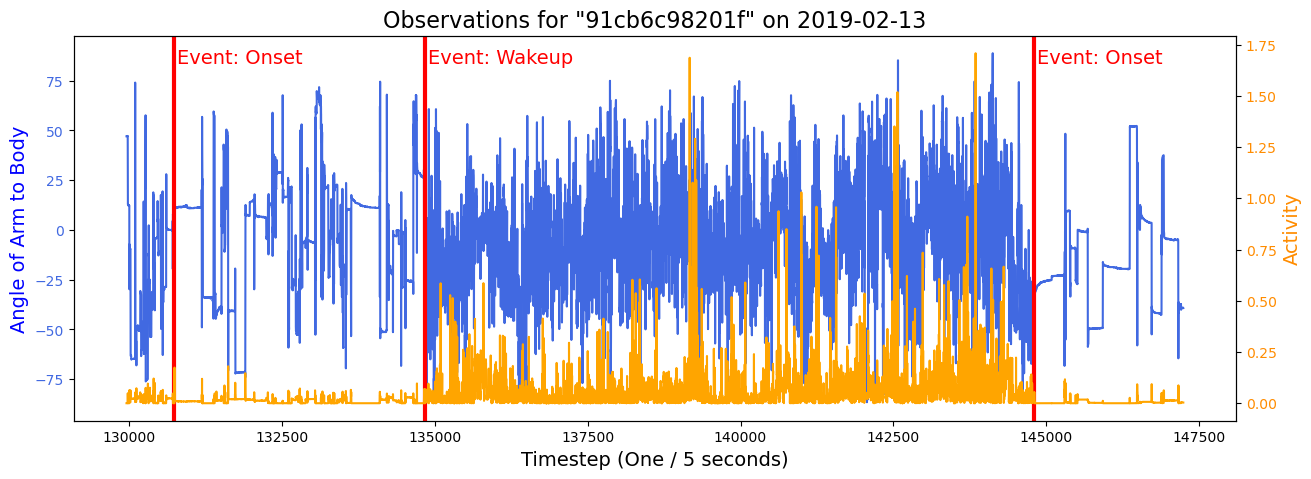

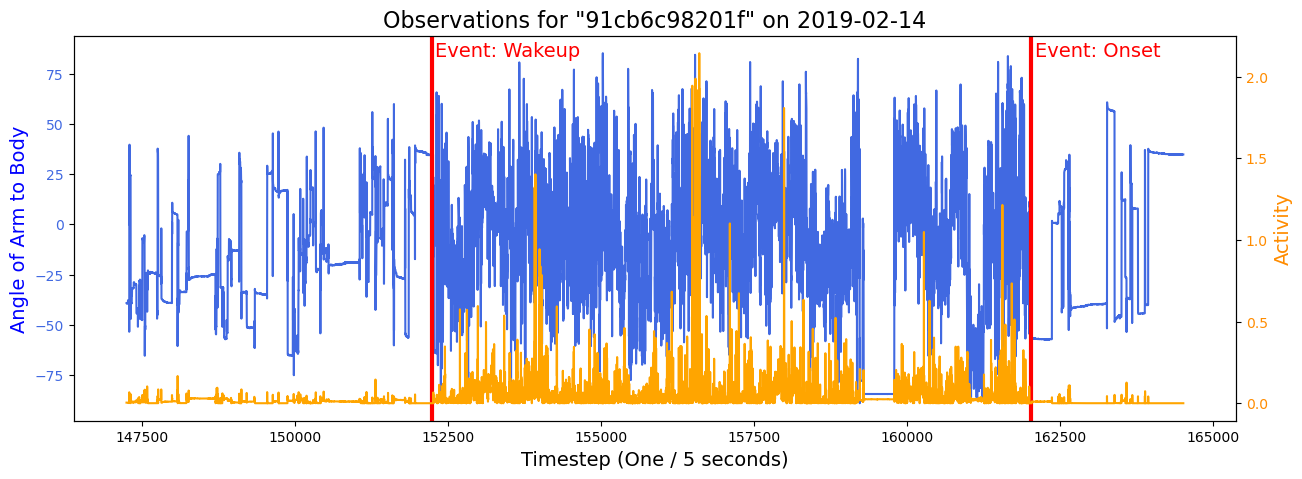

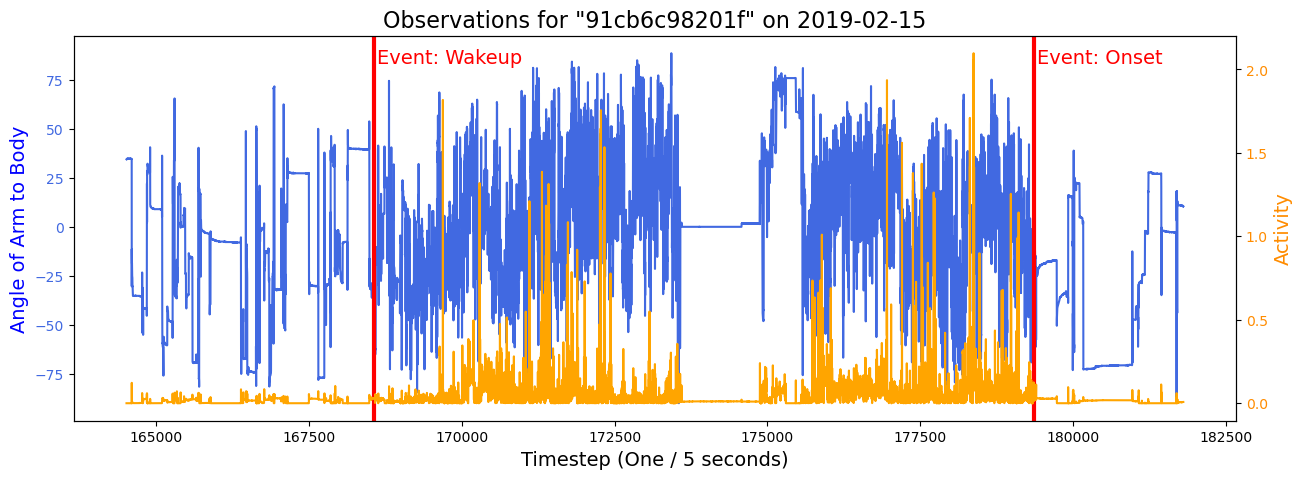

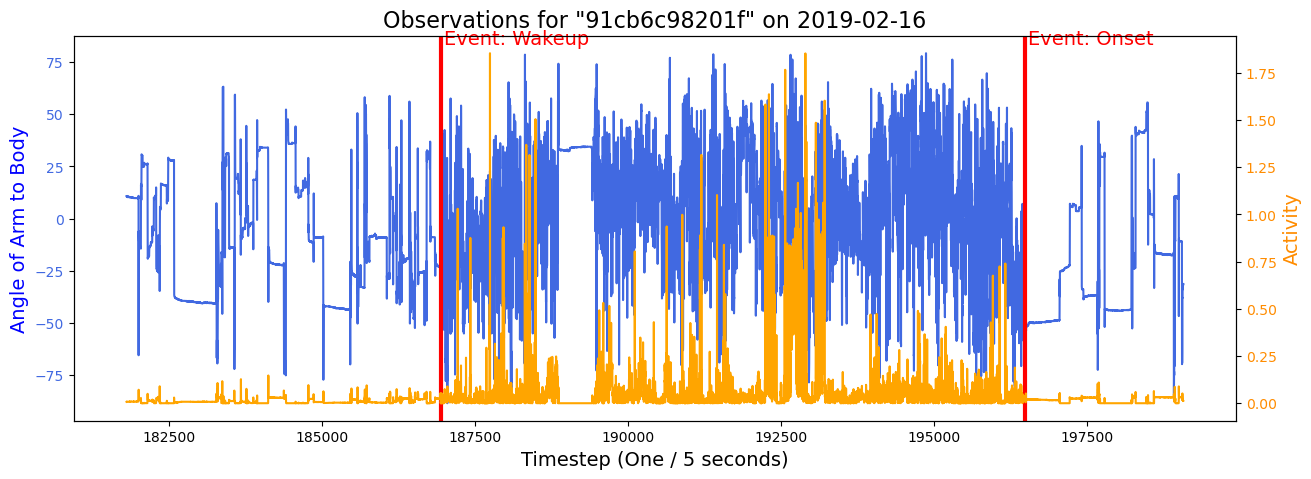

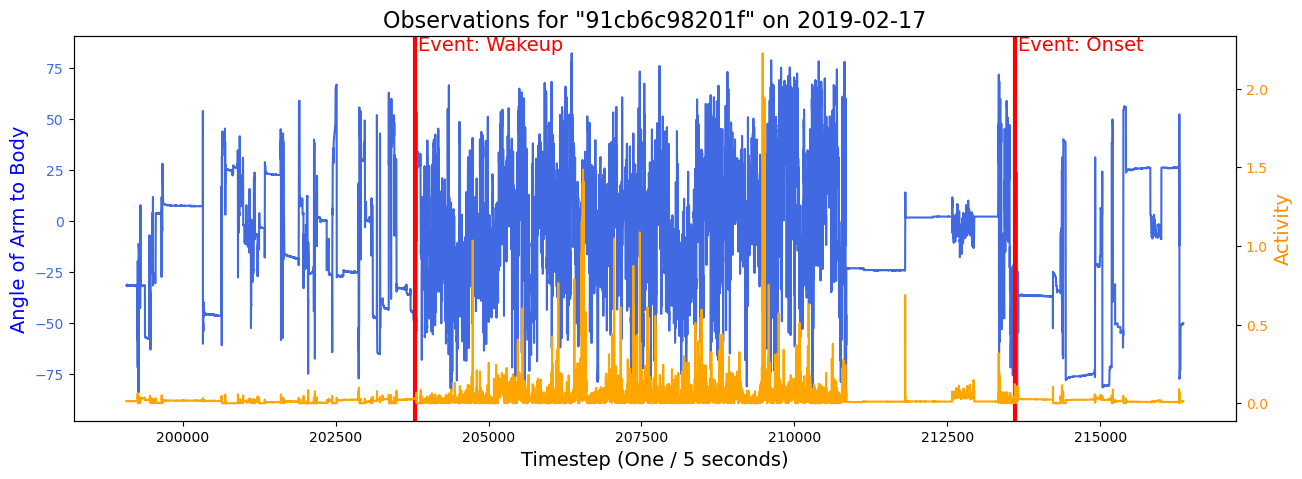

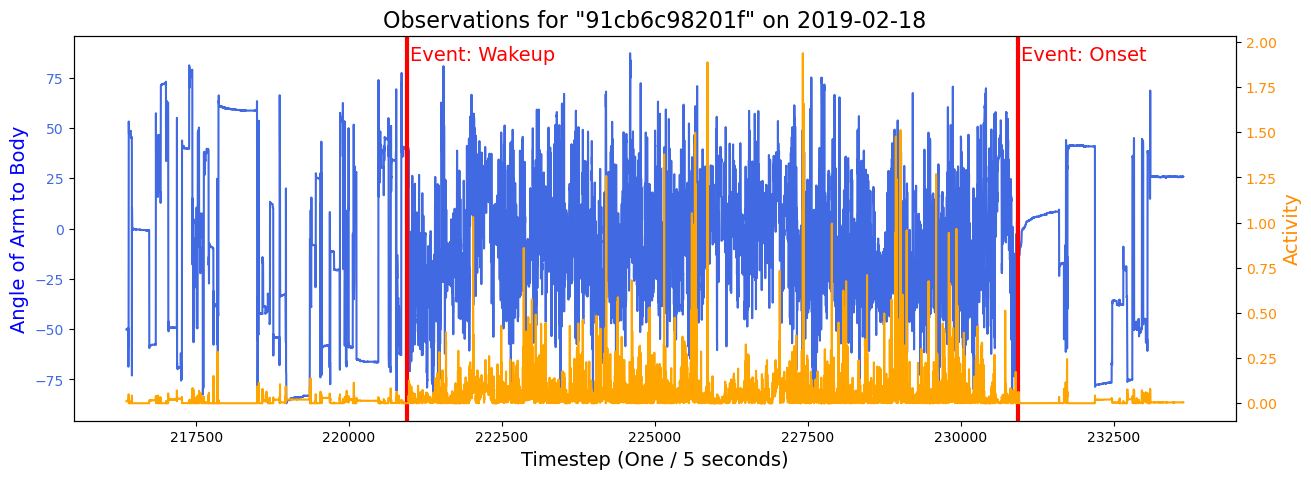

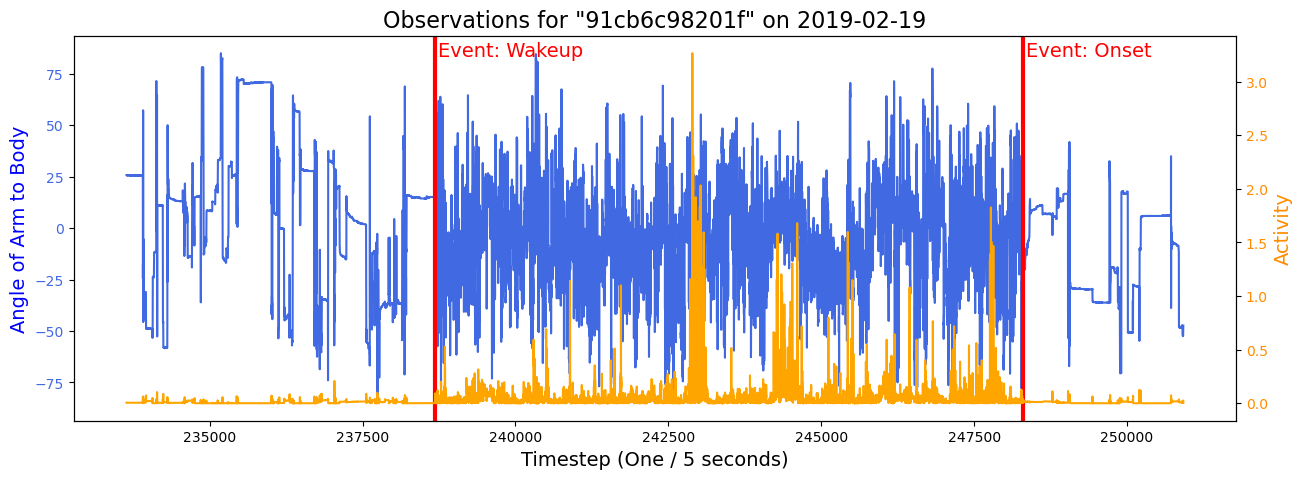

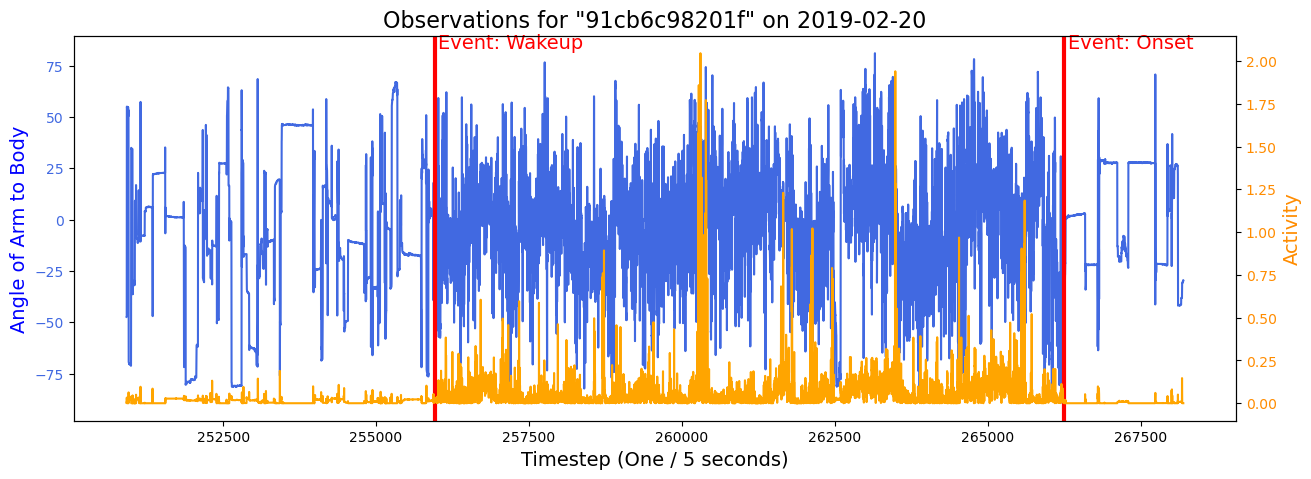

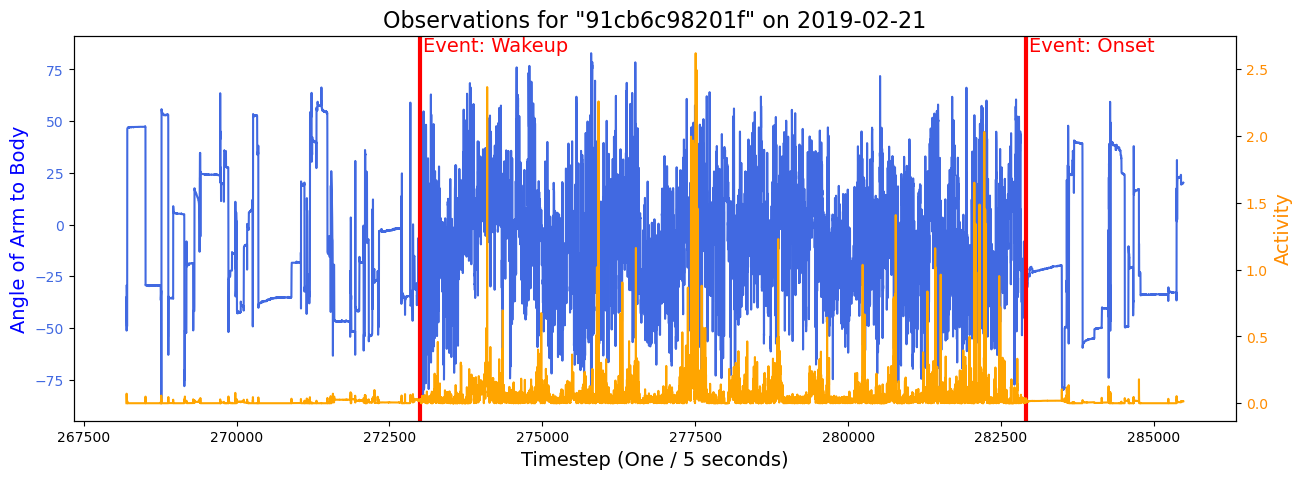

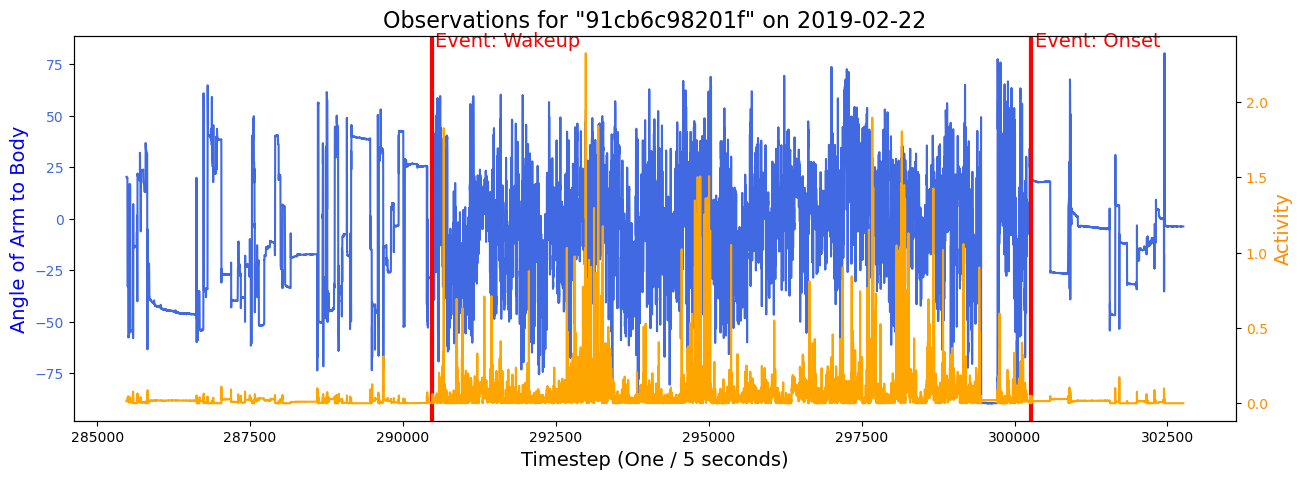

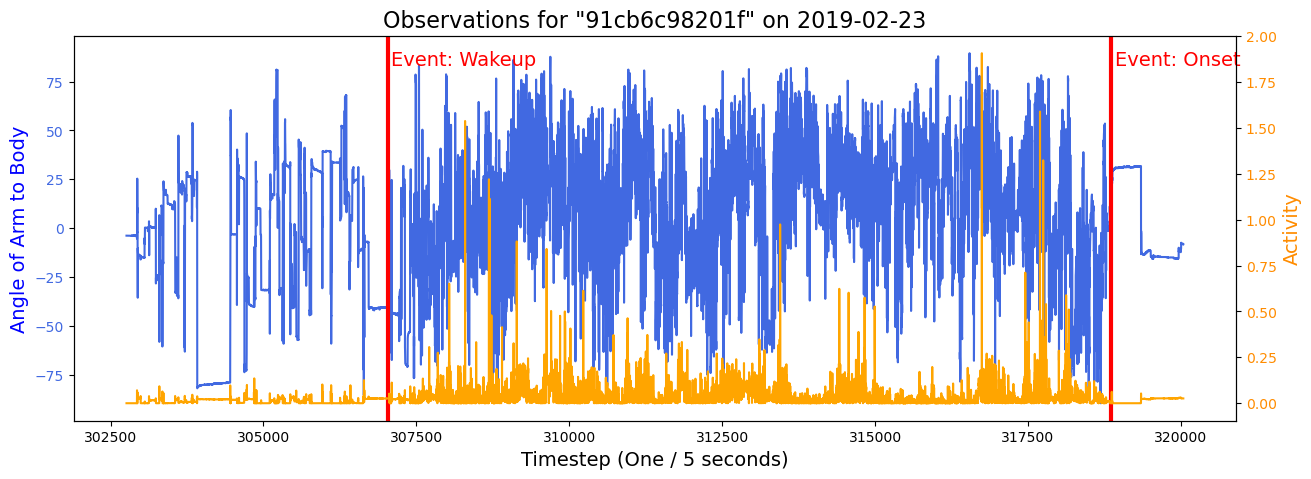

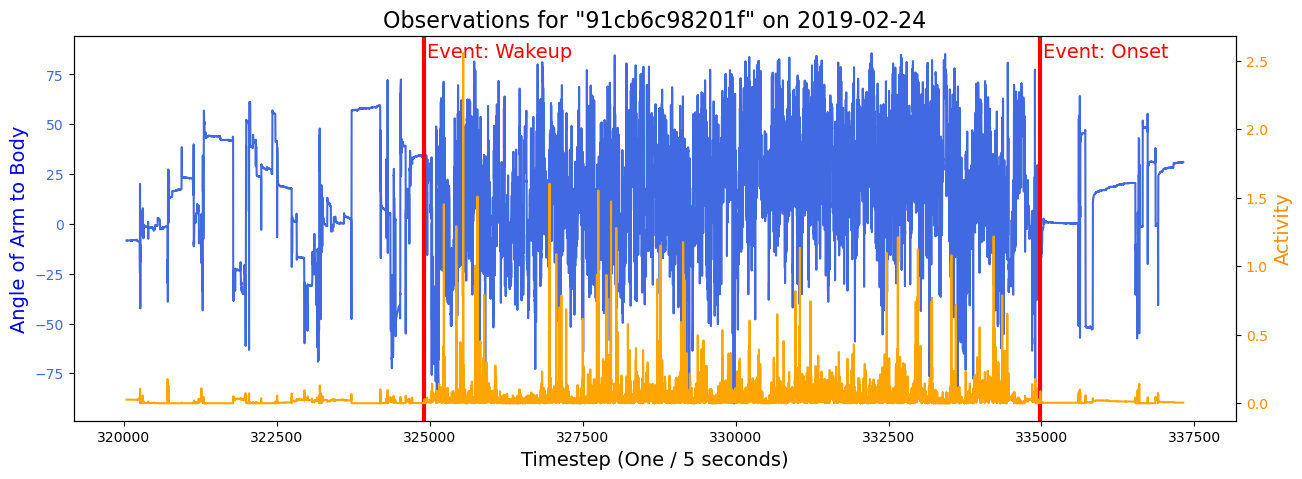

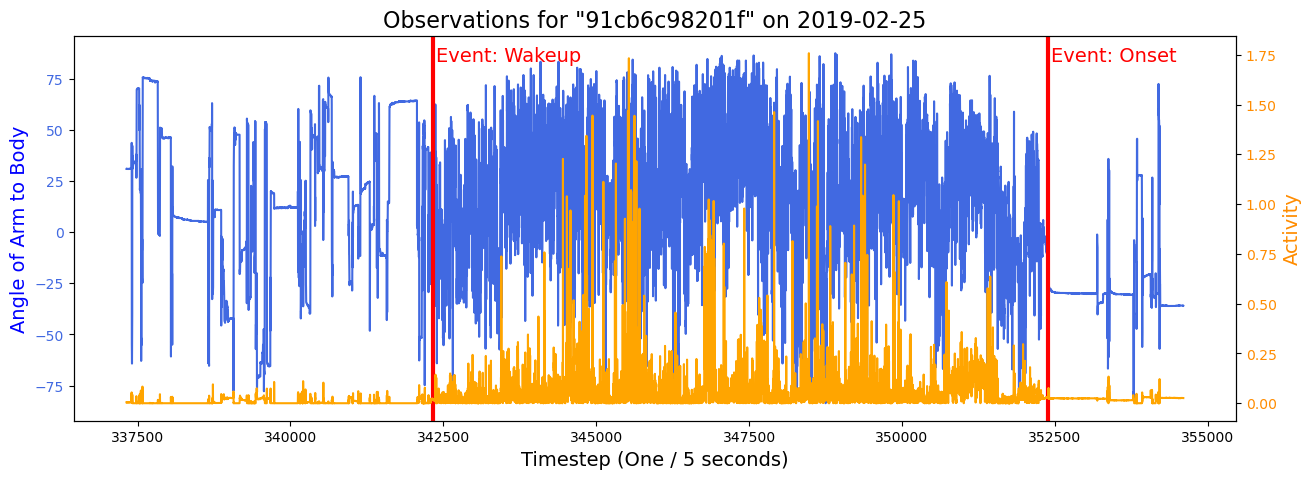

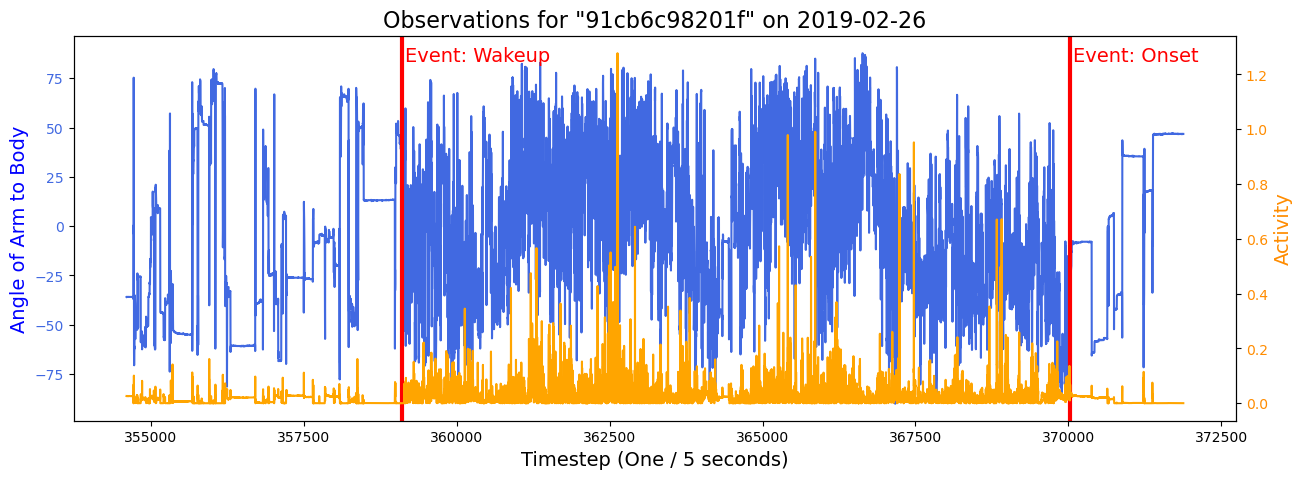

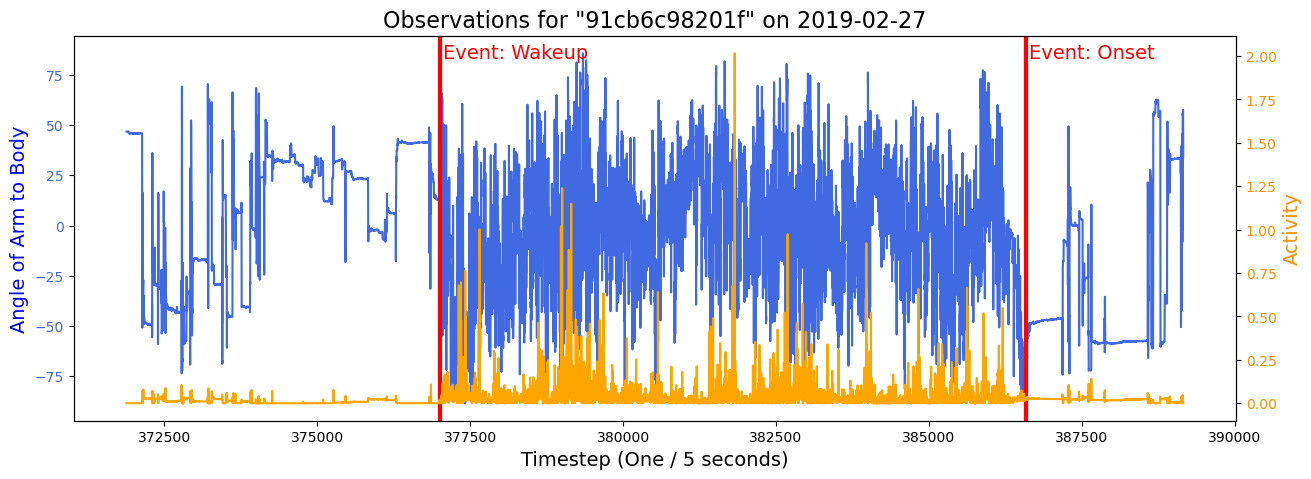

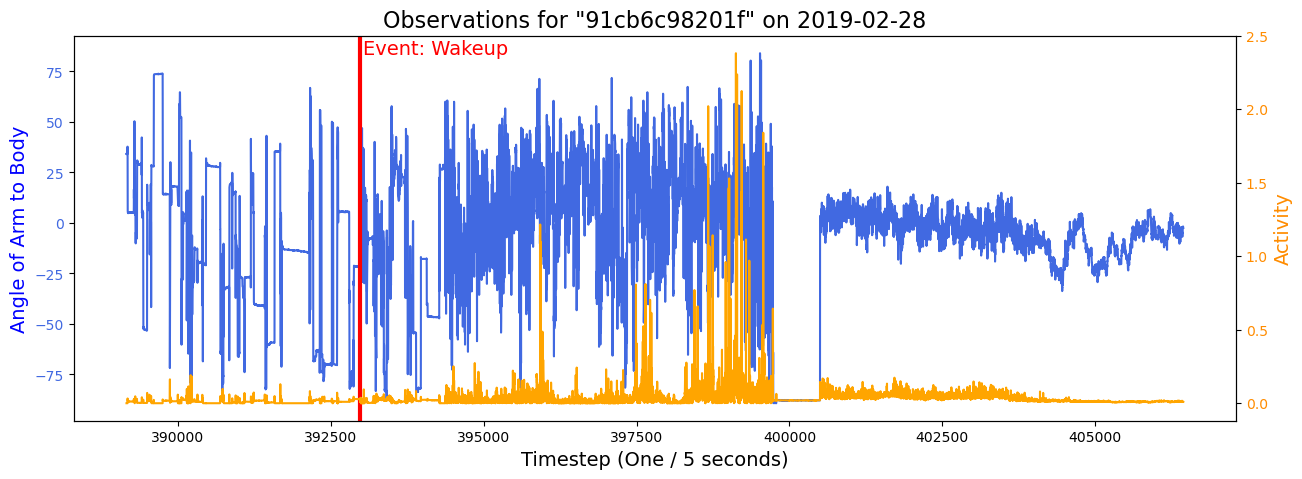

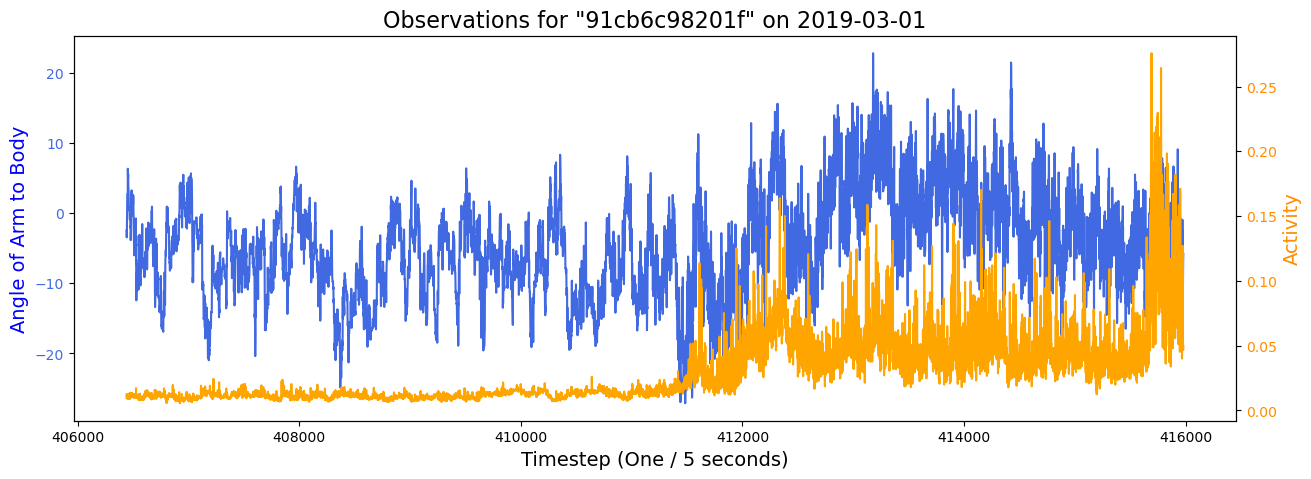

In [239]:
# Plotting the measurements
series_id = data["series_id"].iloc[0]

for i, data in user.groupby("date"):

    fig, ax = plt.subplots(figsize=(15,5))
    data.set_index("step")[["anglez"]].plot(ax=ax, color="royalblue")
    
    ax2 = ax.twinx()
    
    data.set_index("step")["enmo"].plot(ax=ax2, color="orange")
    ax.tick_params("y", labelcolor="royalblue")
    ax2.tick_params("y", labelcolor="darkorange")
    ax.set_xlabel("Timestep (One / 5 seconds)", size=14)
    ax.set_ylabel("Angle of Arm to Body", color="blue", size=14)
    ax2.set_ylabel("Activity", color="darkorange", size=14)
    ax.set_title(f'Observations for "{series_id}" on {i}', size=16)
    
    # Outlining the periods of sleep for labeled events
    step_min = data["step"].min()
    step_max = data["step"].max()
    my_events = user_labels.query('series_id == @series_id and step >= @step_min and step <= @step_max')
    for i, e in my_events.iterrows():
        ax.axvline(x=e["step"], color="red", linewidth=3)
        ax.annotate(xy=((e["step"]+50), 83.5), text=f"Event: {e['event'].title()}", size=14, color="red")
    ax.legend_ = None
    plt.show()
    


In [182]:
user["anglez_20_mean"] = user["anglez"].rolling(20).mean()

In [183]:
user[["anglez_20_mean"]][20:25]

anglez_20_mean
69702500      -77.544850
69702501      -77.543390
69702502      -77.546845
69702503      -77.547240
69702504      -77.547195

In [184]:
user.iloc[20]["anglez"]

-77.5879

In [ ]:
### Function to fill in the the nulls of the rolling features....

In [200]:
def fill_rollers(data, window: int, orig_feature: str, agg_func, agg_func_name:str):
    """
    Function to be used in preprocessing of the sleep study data to fill in the 
    NaNs found in the first {window} number of observations due to the required 
    number of obs to generate a rolling object
    
    data: pandas DataFrame
    window: specified number of observations to initiate a rolling window 
    feature: name of a feature column in "data"
    agg_func: the name of the aggregate function, i.e. "std", used to match the name of the rolling feature
    
    data: dataframe object
    window: int number of observations to form a rolling object
    orig_feature: string name of the original feature that a rolling value was calculated for
    agg_func: function, non-string numpy function used for aggregation, i.e. np.std or np.mean
    agg_func_name: str for naming convention in the resulting dataframe
    """
    
    
    values = data[orig_feature][:window]
    # Build out averages 
    rollers = []
    for i in range(len(values)):
        ma_s = agg_func(values[:i+1])
        rollers.append(ma_s)
    data[f"{orig_feature}_{str(window)}_{agg_func_name}"][:window] = rollers

<hr style="border: 4px solid blue">

# Modeling the data for the first user in the data

In [66]:
df.head()

series_id  step                 timestamp  anglez    enmo
0  038441c925bb   0.0  2018-08-14T15:30:00-0400  2.6367  0.0217
1  038441c925bb   1.0  2018-08-14T15:30:05-0400  2.6368  0.0215
2  038441c925bb   2.0  2018-08-14T15:30:10-0400  2.6370  0.0216
3  038441c925bb   3.0  2018-08-14T15:30:15-0400  2.6368  0.0213
4  038441c925bb   4.0  2018-08-14T15:30:20-0400  2.6368  0.0215

In [67]:
labels.head()

series_id  night   event     step                 timestamp  \
0  038441c925bb      1   onset   4992.0  2018-08-14T22:26:00-0400   
1  038441c925bb      1  wakeup  10932.0  2018-08-15T06:41:00-0400   
2  038441c925bb      2   onset  20244.0  2018-08-15T19:37:00-0400   
3  038441c925bb      2  wakeup  27492.0  2018-08-16T05:41:00-0400   
4  038441c925bb      3   onset  39996.0  2018-08-16T23:03:00-0400   

                        date  
0  2018-08-14 22:26:00-04:00  
1  2018-08-15 06:41:00-04:00  
2  2018-08-15 19:37:00-04:00  
3  2018-08-16 05:41:00-04:00  
4  2018-08-16 23:03:00-04:00

In [140]:
# choosing the first user in the dataframe

user1 = df.query('series_id == "038441c925bb"')
user1_labels = labels.query('series_id == "038441c925bb"')

In [141]:
user1.head()

series_id  step                 timestamp  anglez    enmo
0  038441c925bb   0.0  2018-08-14T15:30:00-0400  2.6367  0.0217
1  038441c925bb   1.0  2018-08-14T15:30:05-0400  2.6368  0.0215
2  038441c925bb   2.0  2018-08-14T15:30:10-0400  2.6370  0.0216
3  038441c925bb   3.0  2018-08-14T15:30:15-0400  2.6368  0.0213
4  038441c925bb   4.0  2018-08-14T15:30:20-0400  2.6368  0.0215

In [98]:
user1["date"] = pd.to_datetime(user1["timestamp"]).dt.date

/var/folders/xb/zg6pgvbs3rb8pr8f0p_697xr0000gn/T/ipykernel_48657/3470863096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user1["date"] = pd.to_datetime(user1["timestamp"]).dt.date


In [143]:
merged = user1.merge(labels, how="left", on=["series_id", "step"], suffixes=["_train", "_label"])

In [144]:
merged.shape

(389880, 9)

In [145]:
merged.head()

series_id  step           timestamp_train  anglez    enmo  night event  \
0  038441c925bb   0.0  2018-08-14T15:30:00-0400  2.6367  0.0217    NaN   NaN   
1  038441c925bb   1.0  2018-08-14T15:30:05-0400  2.6368  0.0215    NaN   NaN   
2  038441c925bb   2.0  2018-08-14T15:30:10-0400  2.6370  0.0216    NaN   NaN   
3  038441c925bb   3.0  2018-08-14T15:30:15-0400  2.6368  0.0213    NaN   NaN   
4  038441c925bb   4.0  2018-08-14T15:30:20-0400  2.6368  0.0215    NaN   NaN   

  timestamp_label date  
0             NaN  NaN  
1             NaN  NaN  
2             NaN  NaN  
3             NaN  NaN  
4             NaN  NaN

In [146]:
# Filling the values in between onset and wakeup
merged["sleep_label"] = merged["event"].fillna(method="ffill")

/var/folders/xb/zg6pgvbs3rb8pr8f0p_697xr0000gn/T/ipykernel_48657/1276780896.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["sleep_label"] = merged["event"].fillna(method="ffill")


#### Verifying ffill() status

In [147]:
merged.loc[4990:4995, "sleep_label"]

4990      NaN
4991      NaN
4992    onset
4993    onset
4994    onset
4995    onset
Name: sleep_label, dtype: object

In [148]:
merged.loc[10930:10935, "sleep_label"]

10930     onset
10931     onset
10932    wakeup
10933    wakeup
10934    wakeup
10935    wakeup
Name: sleep_label, dtype: object

In [149]:
merged["sleep_label"].fillna("wakeup", inplace=True)

In [150]:
# All nulls filled with either onset or wakeup
merged["sleep_label"].isna().sum()

0

In [151]:
merged["numeric_labels"] = merged["sleep_label"].map({"onset":1, "wakeup":0})

### Drop unneccessary values from merged df object:

In [152]:
merged.columns

Index(['series_id', 'step', 'timestamp_train', 'anglez', 'enmo', 'night',
       'event', 'timestamp_label', 'date', 'sleep_label', 'numeric_labels'],
      dtype='object')

In [153]:
merged.head()

series_id  step           timestamp_train  anglez    enmo  night event  \
0  038441c925bb   0.0  2018-08-14T15:30:00-0400  2.6367  0.0217    NaN   NaN   
1  038441c925bb   1.0  2018-08-14T15:30:05-0400  2.6368  0.0215    NaN   NaN   
2  038441c925bb   2.0  2018-08-14T15:30:10-0400  2.6370  0.0216    NaN   NaN   
3  038441c925bb   3.0  2018-08-14T15:30:15-0400  2.6368  0.0213    NaN   NaN   
4  038441c925bb   4.0  2018-08-14T15:30:20-0400  2.6368  0.0215    NaN   NaN   

  timestamp_label date sleep_label  numeric_labels  
0             NaN  NaN      wakeup               0  
1             NaN  NaN      wakeup               0  
2             NaN  NaN      wakeup               0  
3             NaN  NaN      wakeup               0  
4             NaN  NaN      wakeup               0

### Reduced dataframe

In [154]:
merged.drop(columns=['series_id', 'night', 'event', 'timestamp_label'], inplace=True)
merged.set_index("step", inplace=True)
merged.head()

timestamp_train  anglez    enmo date sleep_label  \
step                                                              
0.0   2018-08-14T15:30:00-0400  2.6367  0.0217  NaN      wakeup   
1.0   2018-08-14T15:30:05-0400  2.6368  0.0215  NaN      wakeup   
2.0   2018-08-14T15:30:10-0400  2.6370  0.0216  NaN      wakeup   
3.0   2018-08-14T15:30:15-0400  2.6368  0.0213  NaN      wakeup   
4.0   2018-08-14T15:30:20-0400  2.6368  0.0215  NaN      wakeup   

      numeric_labels  
step                  
0.0                0  
1.0                0  
2.0                0  
3.0                0  
4.0                0

### Features to be engineered:
Knowing that every observation is staggered in 5 second increments, it makes sense to target rolling windows that account for different standard units of measure, i.e. half-minute, minute, 5 minutes, 15 minutes, 30 minutes, and hour.
- Hour of day
- Rolling window features
    - Means
        - anglez -> 6, 12, 60, 180, 360, 720
        - enmo -> 6, 12, 60, 180, 360, 720
    - Std Dev - same windows
    - Var - same windows
- Differenced features: 
    - differenced rolling features are probably more useful than individual observations

- value_counts() based feature: if a measurement's value_counts() are greater than some reasonable value

In [155]:
# Convert timestamp to datetime for hour extraction, then store the hour as a categorical value
merged["timestamp_train"] = pd.to_datetime(merged["timestamp_train"])
merged["hour"] = merged["timestamp_train"].dt.hour.astype(str)

In [156]:
merged.head()

timestamp_train  anglez    enmo date sleep_label  \
step                                                              
0.0  2018-08-14 15:30:00-04:00  2.6367  0.0217  NaN      wakeup   
1.0  2018-08-14 15:30:05-04:00  2.6368  0.0215  NaN      wakeup   
2.0  2018-08-14 15:30:10-04:00  2.6370  0.0216  NaN      wakeup   
3.0  2018-08-14 15:30:15-04:00  2.6368  0.0213  NaN      wakeup   
4.0  2018-08-14 15:30:20-04:00  2.6368  0.0215  NaN      wakeup   

      numeric_labels hour  
step                       
0.0                0   15  
1.0                0   15  
2.0                0   15  
3.0                0   15  
4.0                0   15

In [158]:
def fill_rollers(data, window: int, orig_feature: str, agg_func, agg_func_name:str):
    """
    Function to be used in preprocessing of the sleep study data to fill in the 
    NaNs found in the first {window} number of observations due to the required 
    number of obs to generate a rolling object
    
    data: pandas DataFrame
    window: specified number of observations to initiate a rolling window 
    feature: name of a feature column in "data"
    agg_func: the name of the aggregate function, i.e. "std", used to match the name of the rolling feature
    
    data: dataframe object
    window: int number of observations to form a rolling object
    orig_feature: string name of the original feature that a rolling value was calculated for
    agg_func: function, non-string numpy function used for aggregation, i.e. np.std or np.mean
    agg_func_name: str for naming convention in the resulting dataframe
    """
    
    
    values = data[orig_feature][:window]
    # Build out averages 
    rollers = []
    for i in range(len(values)):
        ma_s = agg_func(values[:i+1])
        rollers.append(ma_s)
    data[f"{orig_feature}_{str(window)}_{agg_func_name}"][:window] = rollers

In [161]:
import warnings
warnings.filterwarnings("ignore")

In [162]:
# anglez feature engineering: MEANS

merged["anglez_6_mean"] = merged["anglez"].rolling(6).mean()
fill_rollers(merged, 6, "anglez", np.mean, "mean")

merged["anglez_12_mean"] = merged["anglez"].rolling(12).mean()
fill_rollers(merged, 12, "anglez", np.mean, "mean")

merged["anglez_60_mean"] = merged["anglez"].rolling(60).mean()
fill_rollers(merged, 60, "anglez", np.mean, "mean")

merged["anglez_180_mean"] = merged["anglez"].rolling(180).mean()
fill_rollers(merged, 180, "anglez", np.mean, "mean")

merged["anglez_360_mean"] = merged["anglez"].rolling(360).mean()
fill_rollers(merged, 360, "anglez", np.mean, "mean")

merged["anglez_720_mean"] = merged["anglez"].rolling(720).mean()
fill_rollers(merged, 720, "anglez", np.mean, "mean")

In [163]:
merged.head()

timestamp_train  anglez    enmo date sleep_label  \
step                                                              
0.0  2018-08-14 15:30:00-04:00  2.6367  0.0217  NaN      wakeup   
1.0  2018-08-14 15:30:05-04:00  2.6368  0.0215  NaN      wakeup   
2.0  2018-08-14 15:30:10-04:00  2.6370  0.0216  NaN      wakeup   
3.0  2018-08-14 15:30:15-04:00  2.6368  0.0213  NaN      wakeup   
4.0  2018-08-14 15:30:20-04:00  2.6368  0.0215  NaN      wakeup   

      numeric_labels hour  anglez_6_mean  anglez_12_mean  anglez_60_mean  \
step                                                                       
0.0                0   15       2.636750        2.636750        2.636750   
1.0                0   15       2.636833        2.636833        2.636833   
2.0                0   15       2.636825        2.636825        2.636825   
3.0                0   15       2.636820        2.636820        2.636820   
4.0                0   15       2.636800        2.636800        2.636800   

      anglez_180_mean  anglez_360_mean  anglez_720_mean  
step                                                     
0.0          2.636750         2.636750         2.636750  
1.0          2.636833         2.636833         2.636833  
2.0          2.636825         2.636825         2.636825  
3.0          2.636820         2.636820         2.636820  
4.0          2.636800         2.636800         2.636800

In [164]:
# anglez feature engineering: STD DEVS

merged["anglez_6_std"] = merged["anglez"].rolling(6).std()
fill_rollers(merged, 6, "anglez", np.std, "std")

merged["anglez_12_std"] = merged["anglez"].rolling(12).std()
fill_rollers(merged, 12, "anglez", np.std, "std")

merged["anglez_60_std"] = merged["anglez"].rolling(60).std()
fill_rollers(merged, 60, "anglez", np.std, "std")

merged["anglez_180_std"] = merged["anglez"].rolling(180).std()
fill_rollers(merged, 180, "anglez", np.std, "std")

merged["anglez_360_std"] = merged["anglez"].rolling(360).std()
fill_rollers(merged, 360, "anglez", np.std, "std")

merged["anglez_720_std"] = merged["anglez"].rolling(720).std()
fill_rollers(merged, 720, "anglez", np.std, "std")

In [166]:
# Allow for more options to be displayed
pd.set_option("display.max_columns", None)

In [167]:
# anglez feature engineering: VARS

merged["anglez_6_var"] = merged["anglez"].rolling(6).var()
fill_rollers(merged, 6, "anglez", np.var, "var")

merged["anglez_12_var"] = merged["anglez"].rolling(12).var()
fill_rollers(merged, 12, "anglez", np.var, "var")

merged["anglez_60_var"] = merged["anglez"].rolling(60).var()
fill_rollers(merged, 60, "anglez", np.var, "var")

merged["anglez_180_var"] = merged["anglez"].rolling(180).var()
fill_rollers(merged, 180, "anglez", np.var, "var")

merged["anglez_360_var"] = merged["anglez"].rolling(360).var()
fill_rollers(merged, 360, "anglez", np.var, "var")

merged["anglez_720_var"] = merged["anglez"].rolling(720).var()
fill_rollers(merged, 720, "anglez", np.var, "var")

In [168]:
merged.head()

timestamp_train  anglez    enmo date sleep_label  \
step                                                              
0.0  2018-08-14 15:30:00-04:00  2.6367  0.0217  NaN      wakeup   
1.0  2018-08-14 15:30:05-04:00  2.6368  0.0215  NaN      wakeup   
2.0  2018-08-14 15:30:10-04:00  2.6370  0.0216  NaN      wakeup   
3.0  2018-08-14 15:30:15-04:00  2.6368  0.0213  NaN      wakeup   
4.0  2018-08-14 15:30:20-04:00  2.6368  0.0215  NaN      wakeup   

      numeric_labels hour  anglez_6_mean  anglez_12_mean  anglez_60_mean  \
step                                                                       
0.0                0   15       2.636750        2.636750        2.636750   
1.0                0   15       2.636833        2.636833        2.636833   
2.0                0   15       2.636825        2.636825        2.636825   
3.0                0   15       2.636820        2.636820        2.636820   
4.0                0   15       2.636800        2.636800        2.636800   

      anglez_180_mean  anglez_360_mean  anglez_720_mean  anglez_6_std  \
step                                                                    
0.0          2.636750         2.636750         2.636750      0.000050   
1.0          2.636833         2.636833         2.636833      0.000125   
2.0          2.636825         2.636825         2.636825      0.000109   
3.0          2.636820         2.636820         2.636820      0.000098   
4.0          2.636800         2.636800         2.636800      0.000100   

      anglez_12_std  anglez_60_std  anglez_180_std  anglez_360_std  \
step                                                                 
0.0        0.000050       0.000050        0.000050        0.000050   
1.0        0.000125       0.000125        0.000125        0.000125   
2.0        0.000109       0.000109        0.000109        0.000109   
3.0        0.000098       0.000098        0.000098        0.000098   
4.0        0.000100       0.000100        0.000100        0.000100   

      anglez_720_std  anglez_6_var  anglez_12_var  anglez_60_var  \
step                                                               
0.0         0.000050  2.506795e-09   2.506795e-09   2.506795e-09   
1.0         0.000125  1.557133e-08   1.557133e-08   1.557133e-08   
2.0         0.000109  1.188640e-08   1.188640e-08   1.188640e-08   
3.0         0.000098  9.608914e-09   9.608914e-09   9.608914e-09   
4.0         0.000100  1.001127e-08   1.001127e-08   1.001127e-08   

      anglez_180_var  anglez_360_var  anglez_720_var  
step                                                  
0.0     2.506795e-09    2.506795e-09    2.506795e-09  
1.0     1.557133e-08    1.557133e-08    1.557133e-08  
2.0     1.188640e-08    1.188640e-08    1.188640e-08  
3.0     9.608914e-09    9.608914e-09    9.608914e-09  
4.0     1.001127e-08    1.001127e-08    1.001127e-08

### Plotting the first few rolling values

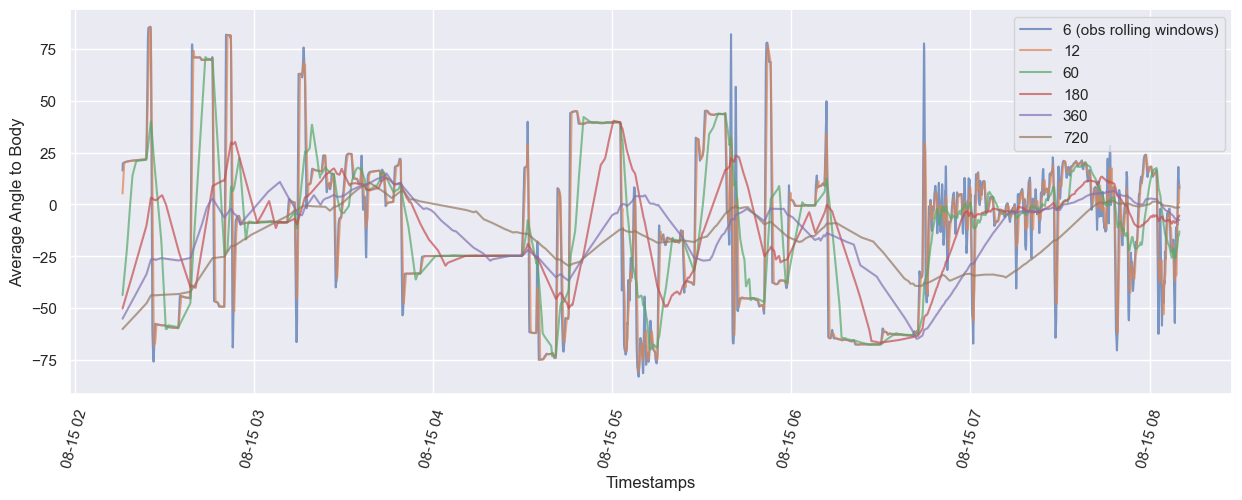

In [170]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15,5))
ex = merged.query('12000 >= step >= 7750')
sns.lineplot(x="timestamp_train", y='anglez_6_mean', data=ex, alpha=.7, ax=ax, label="6 (obs rolling windows)")
sns.lineplot(x="timestamp_train", y='anglez_12_mean', data=ex, alpha=.7, ax=ax, label="12")
sns.lineplot(x="timestamp_train", y='anglez_60_mean', data=ex, alpha=.7, ax=ax, label="60")
sns.lineplot(x="timestamp_train", y='anglez_180_mean', data=ex, alpha=.7, ax=ax, label="180")
sns.lineplot(x="timestamp_train", y='anglez_360_mean', data=ex, alpha=.7, ax=ax, label="360")
sns.lineplot(x="timestamp_train", y='anglez_720_mean', data=ex, alpha=.7, ax=ax, label="720")
plt.legend()
plt.xticks(rotation=75)
ax.set_xlabel("Timestamps")
ax.set_ylabel("Average Angle to Body");

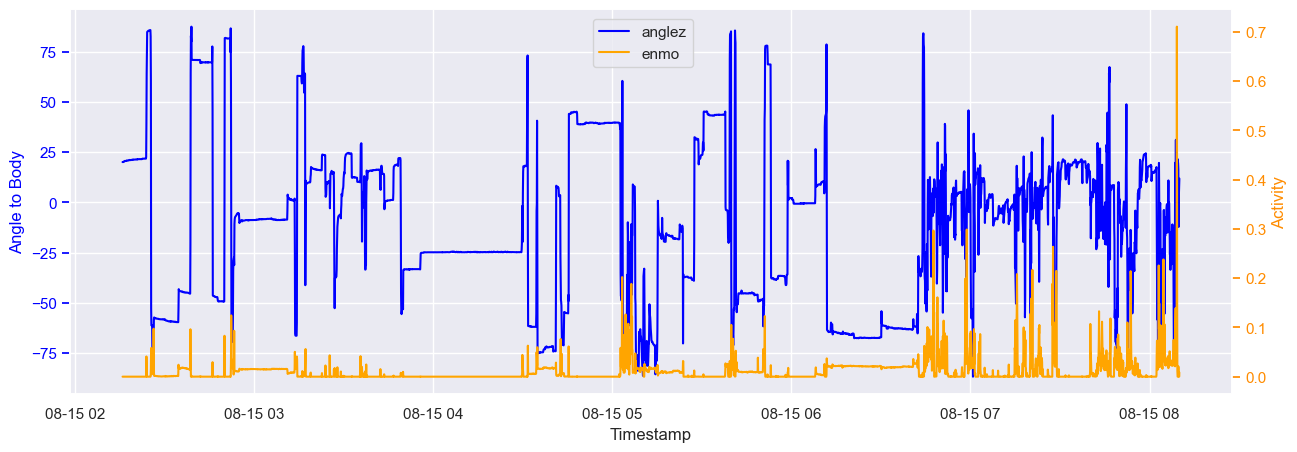

In [172]:
# Comparing these rolling plots to the normal un-altered data for the same time period
from matplotlib.lines import Line2D

fig, ax= plt.subplots(figsize=(15,5))
sns.lineplot(x="timestamp_train", y='anglez', data=ex, ax=ax, color="blue", label="Angle")
ax2 = ax.twinx()
sns.lineplot(x="timestamp_train", y='enmo', data=ex, ax=ax2, color="orange")
ax.legend_ = None

legend_elements = [Line2D([0], [0], color='blue', label='anglez'),
                       Line2D([0], [0], color='orange', label='enmo')]

# add legend manually
ax.legend(handles=legend_elements, loc=(.45,.85))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Angle to Body", color='blue')
ax2.set_ylabel("Activity", color="darkorange")
ax.tick_params("y", colors="blue")
ax2.tick_params("y", colors="darkorange")
plt.grid(False);

### Same thing for enmo

In [174]:
# enmo feature engineering: MEAN

merged["enmo_6_mean"] = merged["enmo"].rolling(6).mean()
fill_rollers(merged, 6, "enmo", np.mean, "mean")

merged["enmo_12_mean"] = merged["enmo"].rolling(12).mean()
fill_rollers(merged, 12, "enmo", np.mean, "mean")

merged["enmo_60_mean"] = merged["enmo"].rolling(60).mean()
fill_rollers(merged, 60, "enmo", np.mean, "mean")

merged["enmo_180_mean"] = merged["enmo"].rolling(180).mean()
fill_rollers(merged, 180, "enmo", np.mean, "mean")

merged["enmo_360_mean"] = merged["enmo"].rolling(360).mean()
fill_rollers(merged, 360, "enmo", np.mean, "mean")

merged["enmo_720_mean"] = merged["enmo"].rolling(720).mean()
fill_rollers(merged, 720, "enmo", np.mean, "mean")

In [175]:
# enmo feature engineering: STD

merged["enmo_6_std"] = merged["enmo"].rolling(6).std()
fill_rollers(merged, 6, "enmo", np.std, "std")

merged["enmo_12_std"] = merged["enmo"].rolling(12).std()
fill_rollers(merged, 12, "enmo", np.std, "std")

merged["enmo_60_std"] = merged["enmo"].rolling(60).std()
fill_rollers(merged, 60, "enmo", np.std, "std")

merged["enmo_180_std"] = merged["enmo"].rolling(180).std()
fill_rollers(merged, 180, "enmo", np.std, "std")

merged["enmo_360_std"] = merged["enmo"].rolling(360).std()
fill_rollers(merged, 360, "enmo", np.std, "std")

merged["enmo_720_std"] = merged["enmo"].rolling(720).std()
fill_rollers(merged, 720, "enmo", np.std, "std")

In [176]:
# enmo feature engineering: VAR

merged["enmo_6_var"] = merged["enmo"].rolling(6).var()
fill_rollers(merged, 6, "enmo", np.var, "var")

merged["enmo_12_var"] = merged["enmo"].rolling(12).var()
fill_rollers(merged, 12, "enmo", np.var, "var")

merged["enmo_60_var"] = merged["enmo"].rolling(60).var()
fill_rollers(merged, 60, "enmo", np.var, "var")

merged["enmo_180_var"] = merged["enmo"].rolling(180).var()
fill_rollers(merged, 180, "enmo", np.var, "var")

merged["enmo_360_var"] = merged["enmo"].rolling(360).var()
fill_rollers(merged, 360, "enmo", np.var, "var")

merged["enmo_720_var"] = merged["enmo"].rolling(720).var()
fill_rollers(merged, 720, "enmo", np.var, "var")

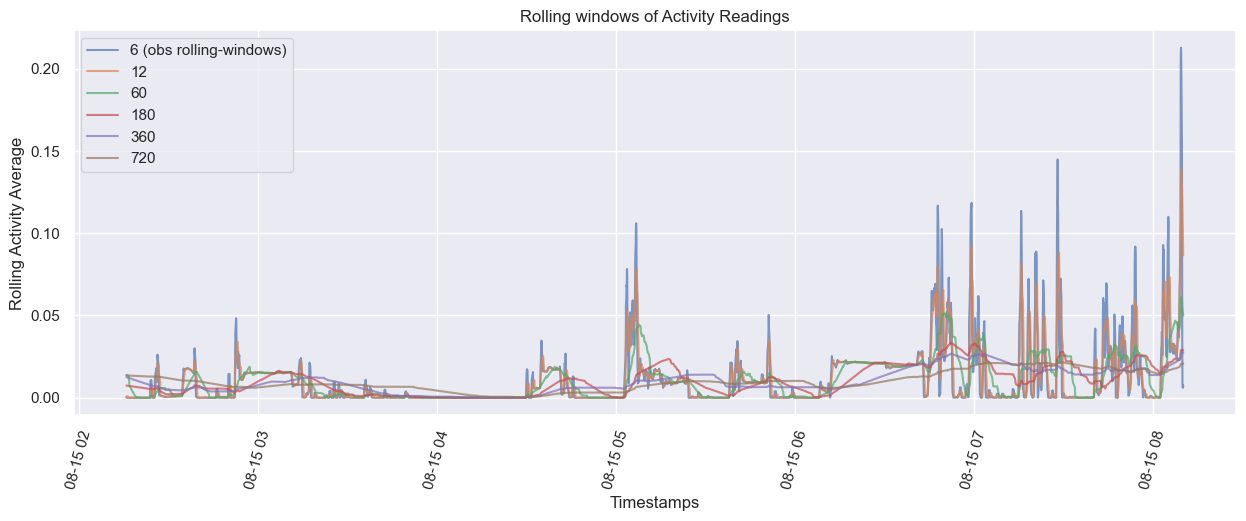

In [177]:
# Rolling Enmo's

fig, ax = plt.subplots(figsize=(15,5))
ex = merged.query('12000 >= step >= 7750')
sns.lineplot(x="timestamp_train", y='enmo_6_mean', data=ex, alpha=.7, ax=ax, label="6 (obs rolling-windows)")
sns.lineplot(x="timestamp_train", y='enmo_12_mean', data=ex, alpha=.7, ax=ax, label="12")
sns.lineplot(x="timestamp_train", y='enmo_60_mean', data=ex, alpha=.7, ax=ax, label="60")
sns.lineplot(x="timestamp_train", y='enmo_180_mean', data=ex, alpha=.7, ax=ax, label="180")
sns.lineplot(x="timestamp_train", y='enmo_360_mean', data=ex, alpha=.7, ax=ax, label="360")
sns.lineplot(x="timestamp_train", y='enmo_720_mean', data=ex, alpha=.7, ax=ax, label="720")
plt.legend()
plt.xticks(rotation=75)
ax.set_title("Rolling windows of Activity Readings")
ax.set_ylabel("Rolling Activity Average")
ax.set_xlabel("Timestamps");

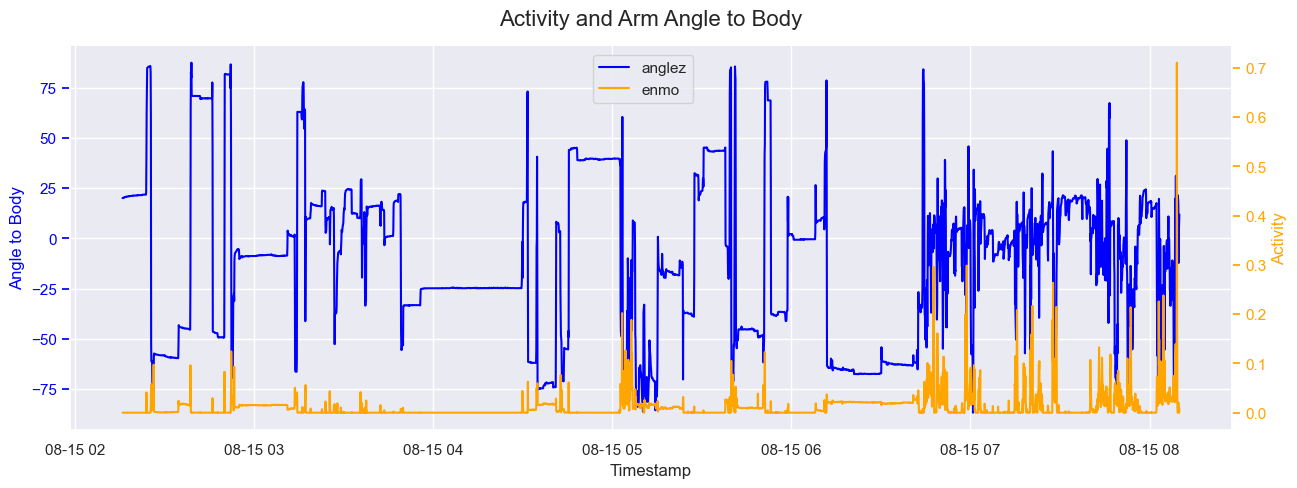

In [178]:
# Comparing these rolling plots to the normal un-altered data for the same time period
from matplotlib.lines import Line2D

fig, ax= plt.subplots(figsize=(15,5))
sns.lineplot(x="timestamp_train", y='anglez', data=ex, ax=ax, color="blue", label="Angle")
ax2 = ax.twinx()
sns.lineplot(x="timestamp_train", y='enmo', data=ex, ax=ax2, color="orange")
ax.legend_ = None

legend_elements = [Line2D([0], [0], color='blue', label='anglez'),
                       Line2D([0], [0], color='orange', label='enmo')]

# add legend manually
ax.legend(handles=legend_elements, loc=(.45,.85))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Angle to Body", color='blue')
ax2.set_ylabel("Activity", color="orange")
ax.tick_params("y", colors="blue")
ax2.tick_params("y", colors="orange")
plt.grid(False)
ax.set_title("Activity and Arm Angle to Body", y=1.03, size=16);

### Initial Observations:
At first glance, the `ENMO` data seem to be much more likely to indicate wakefulness vs sleep. 

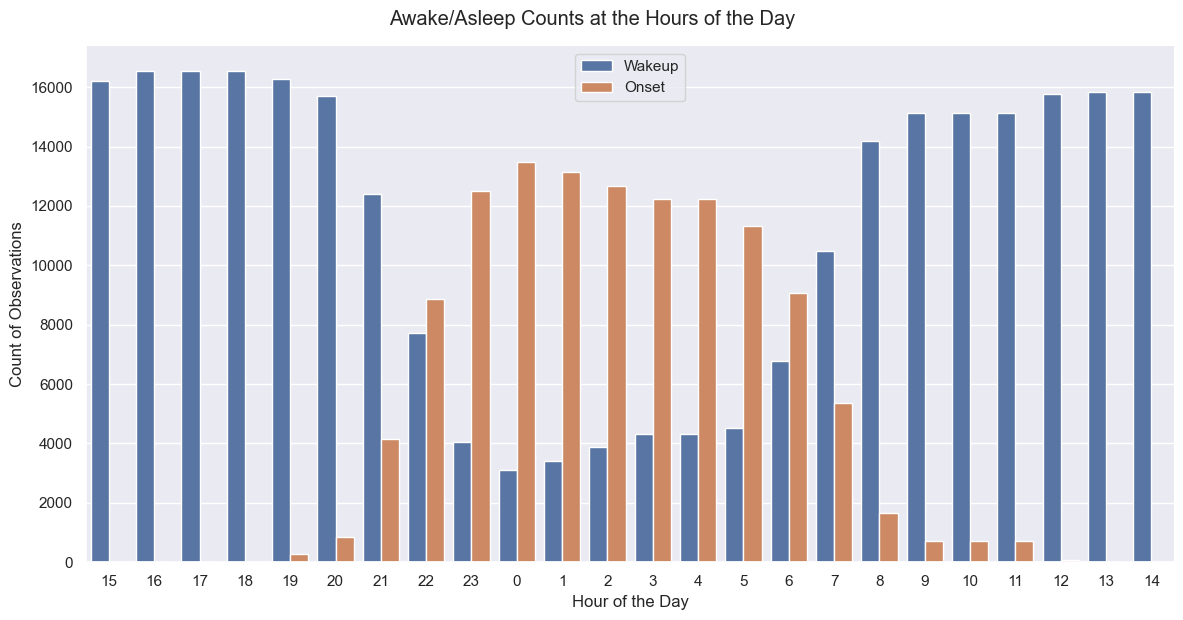

In [186]:
# Plotting the hours of the day and value counts

sns.set_theme()
g = sns.catplot(x="hour", data=merged, kind="count", hue="sleep_label", height=6, aspect=2, legend=False)
g.fig.suptitle("Awake/Asleep Counts at the Hours of the Day", y=1.03)
plt.legend(["Wakeup", "Onset"])
plt.xlabel("Hour of the Day")
plt.ylabel("Count of Observations");

### Next Features: Differenced features

In [187]:
# Checking in on the status of the data

print(merged.shape)
merged.head()

(389880, 43)


timestamp_train  anglez    enmo date sleep_label  \
step                                                              
0.0  2018-08-14 15:30:00-04:00  2.6367  0.0217  NaN      wakeup   
1.0  2018-08-14 15:30:05-04:00  2.6368  0.0215  NaN      wakeup   
2.0  2018-08-14 15:30:10-04:00  2.6370  0.0216  NaN      wakeup   
3.0  2018-08-14 15:30:15-04:00  2.6368  0.0213  NaN      wakeup   
4.0  2018-08-14 15:30:20-04:00  2.6368  0.0215  NaN      wakeup   

      numeric_labels hour  anglez_6_mean  anglez_12_mean  anglez_60_mean  \
step                                                                       
0.0                0   15       2.636750        2.636750        2.636750   
1.0                0   15       2.636833        2.636833        2.636833   
2.0                0   15       2.636825        2.636825        2.636825   
3.0                0   15       2.636820        2.636820        2.636820   
4.0                0   15       2.636800        2.636800        2.636800   

      anglez_180_mean  anglez_360_mean  anglez_720_mean  anglez_6_std  \
step                                                                    
0.0          2.636750         2.636750         2.636750      0.000050   
1.0          2.636833         2.636833         2.636833      0.000125   
2.0          2.636825         2.636825         2.636825      0.000109   
3.0          2.636820         2.636820         2.636820      0.000098   
4.0          2.636800         2.636800         2.636800      0.000100   

      anglez_12_std  anglez_60_std  anglez_180_std  anglez_360_std  \
step                                                                 
0.0        0.000050       0.000050        0.000050        0.000050   
1.0        0.000125       0.000125        0.000125        0.000125   
2.0        0.000109       0.000109        0.000109        0.000109   
3.0        0.000098       0.000098        0.000098        0.000098   
4.0        0.000100       0.000100        0.000100        0.000100   

      anglez_720_std  anglez_6_var  anglez_12_var  anglez_60_var  \
step                                                               
0.0         0.000050  2.506795e-09   2.506795e-09   2.506795e-09   
1.0         0.000125  1.557133e-08   1.557133e-08   1.557133e-08   
2.0         0.000109  1.188640e-08   1.188640e-08   1.188640e-08   
3.0         0.000098  9.608914e-09   9.608914e-09   9.608914e-09   
4.0         0.000100  1.001127e-08   1.001127e-08   1.001127e-08   

      anglez_180_var  anglez_360_var  anglez_720_var  enmo_6_mean  \
step                                                                
0.0     2.506795e-09    2.506795e-09    2.506795e-09     0.021600   
1.0     1.557133e-08    1.557133e-08    1.557133e-08     0.021600   
2.0     1.188640e-08    1.188640e-08    1.188640e-08     0.021525   
3.0     9.608914e-09    9.608914e-09    9.608914e-09     0.021520   
4.0     1.001127e-08    1.001127e-08    1.001127e-08     0.021550   

      enmo_12_mean  enmo_60_mean  enmo_180_mean  enmo_360_mean  enmo_720_mean  \
step                                                                            
0.0       0.021600      0.021600       0.021600       0.021600       0.021600   
1.0       0.021600      0.021600       0.021600       0.021600       0.021600   
2.0       0.021525      0.021525       0.021525       0.021525       0.021525   
3.0       0.021520      0.021520       0.021520       0.021520       0.021520   
4.0       0.021550      0.021550       0.021550       0.021550       0.021550   

      enmo_6_std  enmo_12_std  enmo_60_std  enmo_180_std  enmo_360_std  \
step                                                                     
0.0     0.000100     0.000100     0.000100      0.000100      0.000100   
1.0     0.000082     0.000082     0.000082      0.000082      0.000082   
2.0     0.000148     0.000148     0.000148      0.000148      0.000148   
3.0     0.000133     0.000133     0.000133      0.000133      0.000133   
4.0     0.000138     0.000138     0.

In [188]:
### Let's generate differenced features for 1 minute, 15 minutes, 30 minutes, 60 minutes
def create_diffs(data, original_feature_name, agg_func_name):
    """Add differenced columns for the rolling features
    data: dataframe
    original_feature_name: str -> anglez or enmo
    agg_func_name: str -> i.e. mean, std, var
    """
    
    windows = [12, 180, 360, 720]
    for window in windows:
        data[f"{original_feature_name}_{window}_{agg_func_name}_diff"] = data[f"{original_feature_name}_{window}_{agg_func_name}"].diff(window).fillna(method="bfill")

In [189]:
# Differenced windows for anglez mean over same relative observation length

create_diffs(merged, "anglez", "mean")
create_diffs(merged, "anglez", "mean")
create_diffs(merged, "anglez", "mean")
create_diffs(merged, "anglez", "mean")

In [190]:
# Differenced windwos for enmo mean over same relative observation length

create_diffs(merged, "enmo", "mean")
create_diffs(merged, "enmo", "mean")
create_diffs(merged, "enmo", "mean")
create_diffs(merged, "enmo", "mean")

In [191]:
merged.head()

timestamp_train  anglez    enmo date sleep_label  \
step                                                              
0.0  2018-08-14 15:30:00-04:00  2.6367  0.0217  NaN      wakeup   
1.0  2018-08-14 15:30:05-04:00  2.6368  0.0215  NaN      wakeup   
2.0  2018-08-14 15:30:10-04:00  2.6370  0.0216  NaN      wakeup   
3.0  2018-08-14 15:30:15-04:00  2.6368  0.0213  NaN      wakeup   
4.0  2018-08-14 15:30:20-04:00  2.6368  0.0215  NaN      wakeup   

      numeric_labels hour  anglez_6_mean  anglez_12_mean  anglez_60_mean  \
step                                                                       
0.0                0   15       2.636750        2.636750        2.636750   
1.0                0   15       2.636833        2.636833        2.636833   
2.0                0   15       2.636825        2.636825        2.636825   
3.0                0   15       2.636820        2.636820        2.636820   
4.0                0   15       2.636800        2.636800        2.636800   

      anglez_180_mean  anglez_360_mean  anglez_720_mean  anglez_6_std  \
step                                                                    
0.0          2.636750         2.636750         2.636750      0.000050   
1.0          2.636833         2.636833         2.636833      0.000125   
2.0          2.636825         2.636825         2.636825      0.000109   
3.0          2.636820         2.636820         2.636820      0.000098   
4.0          2.636800         2.636800         2.636800      0.000100   

      anglez_12_std  anglez_60_std  anglez_180_std  anglez_360_std  \
step                                                                 
0.0        0.000050       0.000050        0.000050        0.000050   
1.0        0.000125       0.000125        0.000125        0.000125   
2.0        0.000109       0.000109        0.000109        0.000109   
3.0        0.000098       0.000098        0.000098        0.000098   
4.0        0.000100       0.000100        0.000100        0.000100   

      anglez_720_std  anglez_6_var  anglez_12_var  anglez_60_var  \
step                                                               
0.0         0.000050  2.506795e-09   2.506795e-09   2.506795e-09   
1.0         0.000125  1.557133e-08   1.557133e-08   1.557133e-08   
2.0         0.000109  1.188640e-08   1.188640e-08   1.188640e-08   
3.0         0.000098  9.608914e-09   9.608914e-09   9.608914e-09   
4.0         0.000100  1.001127e-08   1.001127e-08   1.001127e-08   

      anglez_180_var  anglez_360_var  anglez_720_var  enmo_6_mean  \
step                                                                
0.0     2.506795e-09    2.506795e-09    2.506795e-09     0.021600   
1.0     1.557133e-08    1.557133e-08    1.557133e-08     0.021600   
2.0     1.188640e-08    1.188640e-08    1.188640e-08     0.021525   
3.0     9.608914e-09    9.608914e-09    9.608914e-09     0.021520   
4.0     1.001127e-08    1.001127e-08    1.001127e-08     0.021550   

      enmo_12_mean  enmo_60_mean  enmo_180_mean  enmo_360_mean  enmo_720_mean  \
step                                                                            
0.0       0.021600      0.021600       0.021600       0.021600       0.021600   
1.0       0.021600      0.021600       0.021600       0.021600       0.021600   
2.0       0.021525      0.021525       0.021525       0.021525       0.021525   
3.0       0.021520      0.021520       0.021520       0.021520       0.021520   
4.0       0.021550      0.021550       0.021550       0.021550       0.021550   

      enmo_6_std  enmo_12_std  enmo_60_std  enmo_180_std  enmo_360_std  \
step                                                                     
0.0     0.000100     0.000100     0.000100      0.000100      0.000100   
1.0     0.000082     0.000082     0.000082      0.000082      0.000082   
2.0     0.000148     0.000148     0.000148      0.000148      0.000148   
3.0     0.000133     0.000133     0.000133      0.000133      0.000133   
4.0     0.000138     0.000138     0.

<hr style="border: 4px solid blue">

# First Simple Model Initiation 

In [416]:
# Creating the class that will store my data 
from sklearn.model_selection import TimeSeriesSplit

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, X_train, X_test, y_train, y_test, threshold=.5):
        self.name = name
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.threshold = threshold
        
        # for cross val training
        tscv = TimeSeriesSplit(n_splits=5)
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], cv=tscv, n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        if self.threshold == .5:
            self.y_pred = self.model.predict(self.X_test)
        else:
            self.y_pred = (self.model.predict_proba(self.X_test)[:, 1] >= self.threshold).astype(int)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss, "AUC":self.auc}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
        
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        sns.set_style("dark")
        fig, ax = plt.subplots(figsize=(6,6))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, label=f"{self.name} | AUC: {self.auc:.2f})")
        # Y-axis
        ax.set_yticks([0,.2,.4,.6,.8,1])
        ax.set_yticklabels([0,20,40,60,80,100])
        ax.set_ylabel("True Positive %")
        # X-axis
        ax.set_xticks([0,.2,.4,.6,.8,1])
        ax.set_xticklabels([0,20,40,60,80,100])
        ax.set_xlabel("False Positive %")
        ax.set_title(f"{self.name} ROC Curve", fontsize=20)
        plt.grid(False);
        
        
    def compare_roc_curve(self):
        sns.set_style("dark")
        # Color Palette
        colors = sns.color_palette("Paired", n_colors=30)
        # Create the plot
        fig, ax = plt.subplots(figsize=(7,7))
        for i in range(len(Model.model_list)):
            # get the predict_proba values
            y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

            # Get the FPR and TPR data
            fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
            # Plot the actual graph
            ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')
        
        ax.set_title(f"Comparison of ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
        plt.grid(False);
    
    
    def confusion_matrix(self):
        sns.set_style('white')
        # Confusion Matrix Plot
        fig, ax = plt.subplots(figsize=(6,6))
        self.cm = ConfusionMatrixDisplay.from_predictions(y_true=self.y_test, y_pred=self.y_pred, ax=ax)
        plt.title(f'Confusion Matrix for "{self.name}" Test Data');
    
    
    def __str__(self):
      return f"Model name: {self.name}"

In [454]:
def features_from_trees(model_class, length_of_list:int):

    # Extracting feature importances and adding them to a dataframe to contain them for each model

    features = list(model_class.model.get_params()["ct"].get_feature_names_out())
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

    imp_feats = model_class.model.get_params()['model'].feature_importances_

    imp_list = list(zip(features_list, imp_feats))
    imp_dict = dict(imp_list)

    print(f"Top {length_of_list} Feature Importances")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:length_of_list]:
        print(i)
    return imp_dict

In [422]:
def compare_curves(list_of_models):
    sns.set_style("dark")
    # Color Palette
    colors = sns.color_palette("Paired", n_colors=8)
    # Create the plot
    fig, ax = plt.subplots(figsize=(7,7))
    for i in range(len(list_of_models)):
        # get the predict_proba values
        y_hat_hd = list_of_models[i].y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(list_of_models[i].y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, color=colors[i], label=f'{list_of_models[i].name} | AUC: {list_of_models[i].auc:.2f})')

    ax.set_title(f"Comparison of ROC Curves")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    plt.grid(False);

In [426]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier, \
AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, make_scorer

In [417]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389880 entries, 0.0 to 389879.0
Data columns (total 50 columns):
 #   Column                Non-Null Count   Dtype                    
---  ------                --------------   -----                    
 0   timestamp_train       389880 non-null  datetime64[ns, UTC-04:00]
 1   anglez                389880 non-null  float32                  
 2   enmo                  389880 non-null  float32                  
 3   sleep_label           389880 non-null  object                   
 4   numeric_labels        389880 non-null  int64                    
 5   hour                  389880 non-null  object                   
 6   anglez_6_mean         389880 non-null  float64                  
 7   anglez_12_mean        389880 non-null  float64                  
 8   anglez_60_mean        389880 non-null  float64                  
 9   anglez_180_mean       389880 non-null  float64                  
 10  anglez_360_mean       389880 non-null  float6

In [425]:
merged.columns

Index(['timestamp_train', 'anglez', 'enmo', 'sleep_label', 'numeric_labels',
       'hour', 'anglez_6_mean', 'anglez_12_mean', 'anglez_60_mean',
       'anglez_180_mean', 'anglez_360_mean', 'anglez_720_mean', 'enmo_6_mean',
       'enmo_12_mean', 'enmo_60_mean', 'enmo_180_mean', 'enmo_360_mean',
       'enmo_720_mean', 'anglez_6_std', 'anglez_12_std', 'anglez_60_std',
       'anglez_180_std', 'anglez_360_std', 'anglez_720_std', 'anglez_6_var',
       'anglez_12_var', 'anglez_60_var', 'anglez_180_var', 'anglez_360_var',
       'anglez_720_var', 'enmo_6_std', 'enmo_12_std', 'enmo_60_std',
       'enmo_180_std', 'enmo_360_std', 'enmo_720_std', 'enmo_6_var',
       'enmo_12_var', 'enmo_60_var', 'enmo_180_var', 'enmo_360_var',
       'enmo_720_var', 'anglez_12_mean_diff', 'anglez_180_mean_diff',
       'anglez_360_mean_diff', 'anglez_720_mean_diff', 'enmo_12_mean_diff',
       'enmo_180_mean_diff', 'enmo_360_mean_diff', 'enmo_720_mean_diff'],
      dtype='object')

In [424]:
merged.head()

timestamp_train  anglez    enmo sleep_label  numeric_labels  \
step                                                                         
0.0  2018-08-14 15:30:00-04:00  2.6367  0.0217      wakeup               0   
1.0  2018-08-14 15:30:05-04:00  2.6368  0.0215      wakeup               0   
2.0  2018-08-14 15:30:10-04:00  2.6370  0.0216      wakeup               0   
3.0  2018-08-14 15:30:15-04:00  2.6368  0.0213      wakeup               0   
4.0  2018-08-14 15:30:20-04:00  2.6368  0.0215      wakeup               0   

     hour  anglez_6_mean  anglez_12_mean  anglez_60_mean  anglez_180_mean  \
step                                                                        
0.0    15       2.636750        2.636750        2.636750         2.636750   
1.0    15       2.636833        2.636833        2.636833         2.636833   
2.0    15       2.636825        2.636825        2.636825         2.636825   
3.0    15       2.636820        2.636820        2.636820         2.636820   
4.0    15       2.636800        2.636800        2.636800         2.636800   

      anglez_360_mean  anglez_720_mean  enmo_6_mean  enmo_12_mean  \
step                                                                
0.0          2.636750         2.636750     0.021600      0.021600   
1.0          2.636833         2.636833     0.021600      0.021600   
2.0          2.636825         2.636825     0.021525      0.021525   
3.0          2.636820         2.636820     0.021520      0.021520   
4.0          2.636800         2.636800     0.021550      0.021550   

      enmo_60_mean  enmo_180_mean  enmo_360_mean  enmo_720_mean  anglez_6_std  \
step                                                                            
0.0       0.021600       0.021600       0.021600       0.021600      0.000050   
1.0       0.021600       0.021600       0.021600       0.021600      0.000125   
2.0       0.021525       0.021525       0.021525       0.021525      0.000109   
3.0       0.021520       0.021520       0.021520       0.021520      0.000098   
4.0       0.021550       0.021550       0.021550       0.021550      0.000100   

      anglez_12_std  anglez_60_std  anglez_180_std  anglez_360_std  \
step                                                                 
0.0        0.000050       0.000050        0.000050        0.000050   
1.0        0.000125       0.000125        0.000125        0.000125   
2.0        0.000109       0.000109        0.000109        0.000109   
3.0        0.000098       0.000098        0.000098        0.000098   
4.0        0.000100       0.000100        0.000100        0.000100   

      anglez_720_std  anglez_6_var  anglez_12_var  anglez_60_var  \
step                                                               
0.0         0.000050  2.506795e-09   2.506795e-09   2.506795e-09   
1.0         0.000125  1.557133e-08   1.557133e-08   1.557133e-08   
2.0         0.000109  1.188640e-08   1.188640e-08   1.188640e-08   
3.0         0.000098  9.608914e-09   9.608914e-09   9.608914e-09   
4.0         0.000100  1.001127e-08   1.001127e-08   1.001127e-08   

      anglez_180_var  anglez_360_var  anglez_720_var  enmo_6_std  enmo_12_std  \
step                                                                            
0.0     2.506795e-09    2.506795e-09    2.506795e-09    0.000100     0.000100   
1.0     1.557133e-08    1.557133e-08    1.557133e-08    0.000082     0.000082   
2.0     1.188640e-08    1.188640e-08    1.188640e-08    0.000148     0.000148   
3.0     9.608914e-09    9.608914e-09    9.608914e-09    0.000133     0.000133   
4.0     1.001127e-08    1.001127e-08    1.001127e-08    0.000138     0.000138   

      enmo_60_std  enmo_180_std  enmo_360_std  enmo_720_std    enmo_6_var  \
step                                                                        
0.0      0.000100      0.000100      0.000100      0.000100  9.999966e-09   
1.0      0.000082      0.000082      0.000082      0.000082  6.666644e-09   
2.0      0.000148      0.000148 

In [427]:
X = merged.drop(columns=['timestamp_train', 'sleep_label', 'numeric_labels'])
y = merged["numeric_labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, shuffle=False, test_size=.2)

In [428]:
# One Hot Encode the Hour column, everything else can be scaled using MinMaxScaler

# Sub-pipe for numeric transformation
num_pipe = Pipeline(steps=[
    ("mm", MinMaxScaler())
])

# Sub-pipe for categorical transformation
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Column Transformer object to be given to the ultimate pipeline model
ct = ColumnTransformer(transformers=[
    ("num_pipe", num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])

In [453]:
pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", XGBRFClassifier(n_jobs=6))
])

pipe.fit(X_train, y_train)

# DummyClassifier()
# RFC
# XGB
# KNN
# XGBRFC

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('mm',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe063b2aa40>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe063b28d00>)])),...
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=100, n_jobs=6,
                                 num_parallel_tree=None,
                                 objective='binary:logistic', predictor=None,
                                 random_state=None, reg_alpha=None, ...))])

In [458]:
# dummy1= Model("Dummy Classifier", pipe, X_train, X_test, y_train, y_test)
# rfc1= Model("RFC Default", pipe, X_train, X_test, y_train, y_test)
# xgb1= Model("XGB Default", pipe, X_train, X_test, y_train, y_test)
# knn1= Model("KNN Default", pipe, X_train, X_test, y_train, y_test)  # took a VERY long time
xgb_rfc1= Model("XGBRFC Default", pipe, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future ver

In [468]:
Model.model_df.sort_values("test_accuracy", ascending=False)

name  train_accuracy  train_prec  train_recall  train_f1  \
2       XGB Default        0.905636    0.838040      0.874395  0.849740   
1       RFC Default        0.900177    0.817165      0.879395  0.842962   
3       KNN Default        0.883703    0.836807      0.786520  0.803894   
4    XGBRFC Default        0.868917    0.753244      0.880236  0.805319   
0  Dummy Classifier        0.688412    0.000000      0.000000  0.000000   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
2       0.468944       0.938661   0.855872     0.935035  0.893704   
1       0.259207       0.938314   0.860749     0.926153  0.892254   
3       3.996525       0.914422   0.834619     0.860119  0.847177   
4       0.362495       0.909370   0.818038     0.863421  0.840117   
0      11.230776       0.724223   0.000000     0.000000  0.000000   

   test_logloss       AUC  
2      0.237213  0.984539  
1      0.193195  0.977866  
3      2.857326  0.904719  
4      0.285530  0.961645  
0      9.940016  0.500000

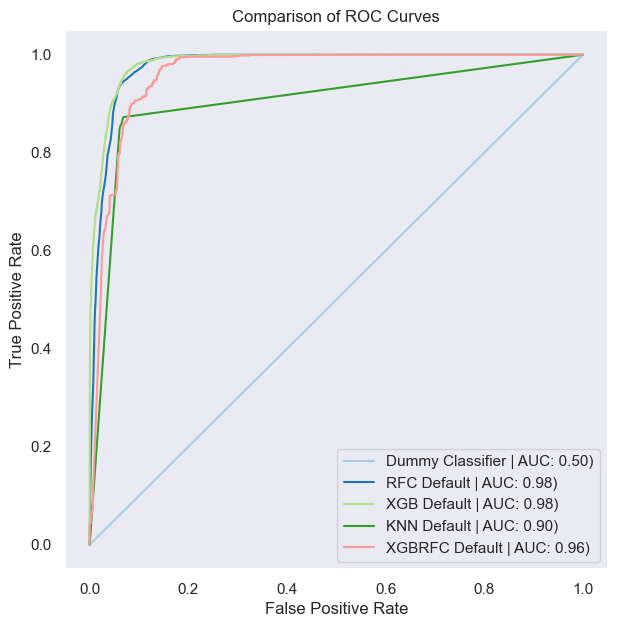

In [469]:
compare_curves([dummy1, rfc1, xgb1, knn1, xgb_rfc1])

In [455]:
rfc_dict = features_from_trees(rfc1, 10)

Top 10 Feature Importances
('anglez_6_var', 0.07059698031809451)
('enmo_360_mean', 0.060544214183299784)
('enmo_720_var', 0.05872969548548523)
('enmo_720_mean', 0.05795127188140869)
('anglez_6_std', 0.057086743359074925)
('enmo_720_std', 0.05612679067244944)
('enmo_6_std', 0.04133455576758989)
('anglez_12_var', 0.03676151508555466)
('anglez_720_mean', 0.030353672934012078)
('enmo_360_std', 0.02819719150329587)


In [456]:
xgb_dict = features_from_trees(xgb1, 10)

Top 10 Feature Importances
('anglez_6_std', 0.35566843)
('enmo_720_mean', 0.053534396)
('enmo_12_std', 0.04568844)
('anglez_12_std', 0.04526693)
('enmo_360_mean', 0.030508451)
('hour_15', 0.023438465)
('hour_17', 0.023274079)
('anglez_720_mean', 0.021998608)
('hour_12', 0.021928236)
('anglez_720_std', 0.018803718)


In [463]:
xgb_rfc_dict = features_from_trees(xgb_rfc1, 10)

Top 10 Feature Importances
('enmo_6_std', 0.28327462)
('anglez_6_std', 0.22676142)
('anglez_6_var', 0.2192699)
('enmo_6_var', 0.081698745)
('enmo_720_mean', 0.027491089)
('anglez_720_std', 0.012720542)
('anglez_360_mean', 0.012398207)
('anglez_720_var', 0.010394449)
('enmo_720_var', 0.008164031)
('anglez_720_mean', 0.007796303)


In [467]:
sorted(list(xgb_rfc_dict.items()), key=lambda x: x[1], reverse=True)

[('enmo_6_std', 0.28327462),
 ('anglez_6_std', 0.22676142),
 ('anglez_6_var', 0.2192699),
 ('enmo_6_var', 0.081698745),
 ('enmo_720_mean', 0.027491089),
 ('anglez_720_std', 0.012720542),
 ('anglez_360_mean', 0.012398207),
 ('anglez_720_var', 0.010394449),
 ('enmo_720_var', 0.008164031),
 ('anglez_720_mean', 0.007796303),
 ('hour_14', 0.007772121),
 ('enmo_720_std', 0.0076484527),
 ('hour_17', 0.0072474023),
 ('enmo_360_mean', 0.0061459066),
 ('hour_5', 0.005217302),
 ('hour_12', 0.004299794),
 ('anglez_60_mean', 0.003467625),
 ('hour_15', 0.0034522738),
 ('enmo_360_var', 0.0033228442),
 ('anglez_12_std', 0.0033060818),
 ('hour_23', 0.003201108),
 ('hour_0', 0.0029088343),
 ('anglez_360_std', 0.0029025564),
 ('enmo_360_mean_diff', 0.0028007512),
 ('enmo_360_std', 0.002745891),
 ('hour_21', 0.002726346),
 ('enmo_180_std', 0.002591251),
 ('hour_22', 0.002577035),
 ('anglez_180_mean', 0.0024170699),
 ('anglez_180_std', 0.0023495397),
 ('anglez_6_mean', 0.0023090448),
 ('anglez_180_var', 0.

# Modeling without the HOURS feature 

In [471]:
# Adding "hour" to the dropped columns

X = merged.drop(columns=['hour', 'timestamp_train', 'sleep_label', 'numeric_labels'])
y = merged["numeric_labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, shuffle=False, test_size=.2)

In [472]:
# One Hot Encode the Hour column, everything else can be scaled using MinMaxScaler

# Sub-pipe for numeric transformation
num_pipe = Pipeline(steps=[
    ("mm", MinMaxScaler())
])

# Sub-pipe for categorical transformation
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Column Transformer object to be given to the ultimate pipeline model
ct = ColumnTransformer(transformers=[
    ("num_pipe", num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])

In [488]:
pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", XGBRFClassifier(n_jobs=6))
])

pipe.fit(X_train, y_train)

# DummyClassifier()
# RFC
# XGB
# KNN
# XGBRFC

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('mm',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe0ac989f60>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe0ac98be50>)])),...
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=100, n_jobs=6,
                                 num_parallel_tree=None,
                                 objective='binary:logistic', predictor=None,
                                 random_state=None, reg_alpha=None, ...))])

In [490]:
# dummy1_no_hours = Model("Dummy Classifier w/o 'hours'", pipe, X_train, X_test, y_train, y_test)
# rfc1_no_hours = Model("RFC Default w/o 'hours'", pipe, X_train, X_test, y_train, y_test)
# xgb1_no_hours = Model("XGB Default w/o 'hours'", pipe, X_train, X_test, y_train, y_test)
# knn1_no_hours = Model("KNN Default w/o 'hours'", pipe, X_train, X_test, y_train, y_test)  # took a VERY long time
# xgb_rfc1_no_hours = Model("XGBRFC Default w/o 'hours'", pipe, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future ver

In [509]:
Model.model_df.sort_values("test_accuracy", ascending=False)

name  train_accuracy  train_prec  train_recall  \
2                   XGB Default        0.905636    0.838040      0.874395   
1                   RFC Default        0.900177    0.817165      0.879395   
6       RFC Default w/o 'hours'        0.888600    0.802930      0.856463   
7       XGB Default w/o 'hours'        0.894868    0.831076      0.835503   
3                   KNN Default        0.883703    0.836807      0.786520   
9    XGBRFC Default w/o 'hours'        0.859311    0.761361      0.822300   
4                XGBRFC Default        0.868917    0.753244      0.880236   
8       KNN Default w/o 'hours'        0.847726    0.751729      0.767733   
0              Dummy Classifier        0.688412    0.000000      0.000000   
5  Dummy Classifier w/o 'hours'        0.688412    0.000000      0.000000   

   train_f1  train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
2  0.849740       0.468944       0.938661   0.855872     0.935035  0.893704   
1  0.842962       0.259207       0.938314   0.860749     0.926153  0.892254   
6  0.823869       0.296821       0.928350   0.852817     0.894578  0.873199   
7  0.828304       0.535406       0.924887   0.859024     0.870489  0.864719   
3  0.803894       3.996525       0.914422   0.834619     0.860119  0.847177   
9  0.782707       0.367591       0.913191   0.830871     0.860352  0.845354   
4  0.805319       0.362495       0.909370   0.818038     0.863421  0.840117   
8  0.754275       4.931342       0.904599   0.820870     0.836635  0.828677   
0  0.000000      11.230776       0.724223   0.000000     0.000000  0.000000   
5  0.000000      11.230776       0.724223   0.000000     0.000000  0.000000   

   test_logloss       AUC          hours  
2      0.237213  0.984539  Without Hours  
1      0.193195  0.977866  Without Hours  
6      0.197955  0.972752     With Hours  
7      0.301681  0.973346     With Hours  
3      2.857326  0.904719  Without Hours  
9      0.275228  0.961827     With Hours  
4      0.285530  0.961645  Without Hours  
8      2.879389  0.900391     With Hours  
0      9.940016  0.500000  Without Hours  
5      9.940016  0.500000     With Hours

In [479]:
rfc_no_hrs = features_from_trees(rfc1_no_hours, 10)

Top 10 Feature Importances
('enmo_720_mean', 0.0739771628682556)
('enmo_720_std', 0.06435354111319998)
('enmo_360_mean', 0.06257771914524535)
('anglez_6_std', 0.06122436704086833)
('anglez_6_var', 0.060870904760436786)
('anglez_12_std', 0.04519966886567364)
('enmo_720_var', 0.04210034737801384)
('anglez_720_std', 0.03611874922679007)
('enmo_360_std', 0.03430542768729502)
('anglez_720_var', 0.03114582512579752)


In [484]:
xgb_no_hrs = features_from_trees(rfc1_no_hours, 10)

Top 10 Feature Importances
('enmo_720_mean', 0.0739771628682556)
('enmo_720_std', 0.06435354111319998)
('enmo_360_mean', 0.06257771914524535)
('anglez_6_std', 0.06122436704086833)
('anglez_6_var', 0.060870904760436786)
('anglez_12_std', 0.04519966886567364)
('enmo_720_var', 0.04210034737801384)
('anglez_720_std', 0.03611874922679007)
('enmo_360_std', 0.03430542768729502)
('anglez_720_var', 0.03114582512579752)


In [494]:
Model.model_df["hours"] = Model.model_df["name"].str.contains("w/o 'hours'").map({True:"With Hours", False:"Without Hours"})

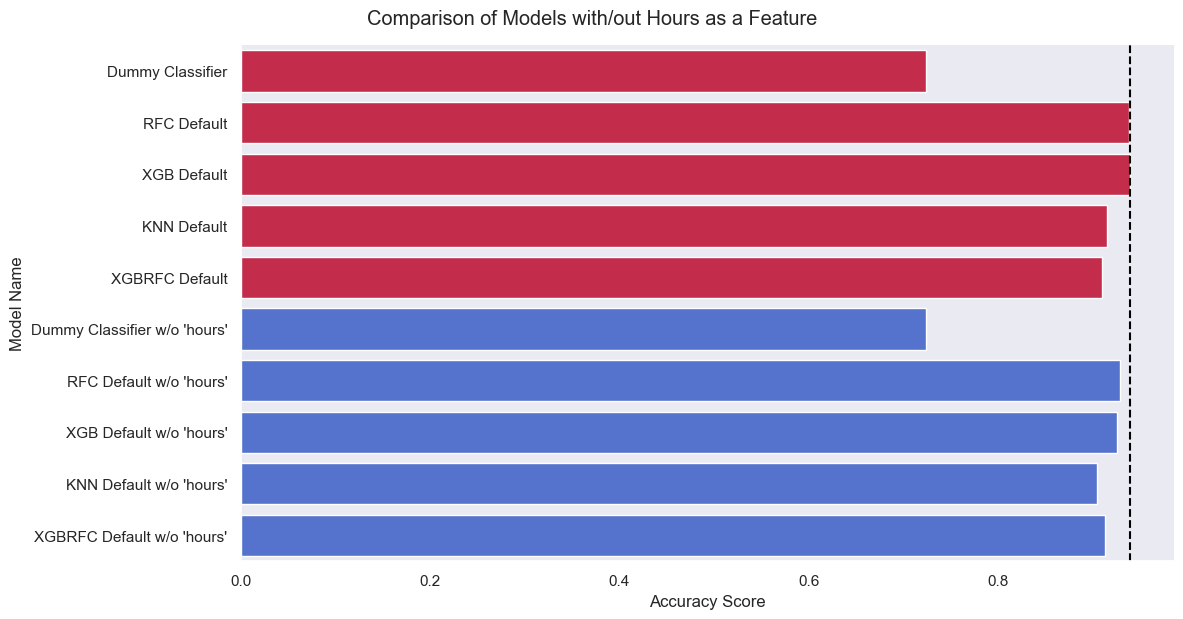

In [508]:
custom_palette = ["royalblue" if "w/o" in name else "crimson" for name in Model.model_df["name"]]
g = sns.catplot(y="name", x="test_accuracy", data=Model.model_df, kind="bar", height=6, aspect=2, palette=custom_palette)
g.fig.suptitle("Comparison of Models with/out Hours as a Feature", y=1.03)
g.set_titles("With {col_name} as")
plt.ylabel("Model Name")
plt.xlabel("Accuracy Score")
plt.axvline(x=Model.model_df["test_accuracy"].max(), color="black", linestyle="--");

In [511]:
labels["timestamp"] = pd.to_datetime()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB


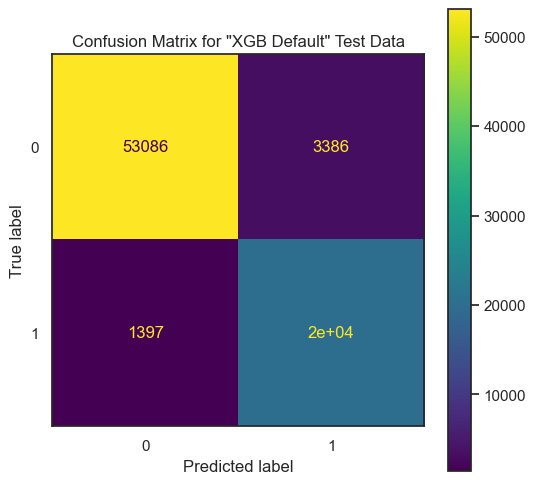

In [512]:
xgb1.confusion_matrix()

In [518]:
pd.Series(xgb1_no_hours.model.predict(X_test)).value_counts()

0    56185
1    21791
Name: count, dtype: int64

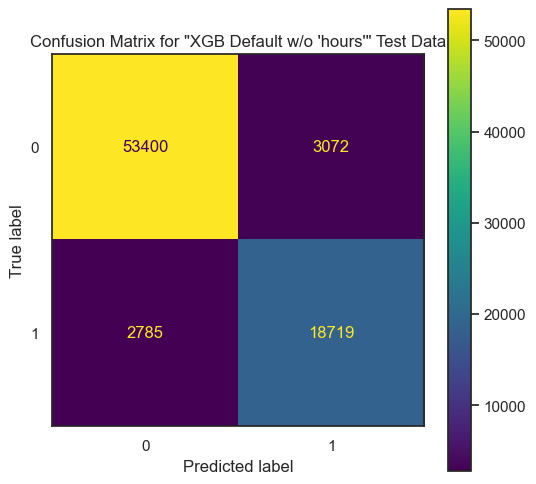

In [520]:
# Best model's confusion matrix without Hours feature

xgb1_no_hours.confusion_matrix()

# Is there a way we can give our model insight so that wakeup/onset is only predicted ONCE DAILY??? Still a good question.... we will have to address this at a later point in time. 